In [2]:
# Imports
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt

import numpy as np

from pyro.distributions.relaxed_straight_through import RelaxedBernoulliStraightThrough

import autoencoders

from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_nrmse as nrmse

import pandas as pd
import seaborn as sns

In [2]:
# Load dataframe
df = pd.read_pickle("./Dataframes/MNIST_DF.pkl")

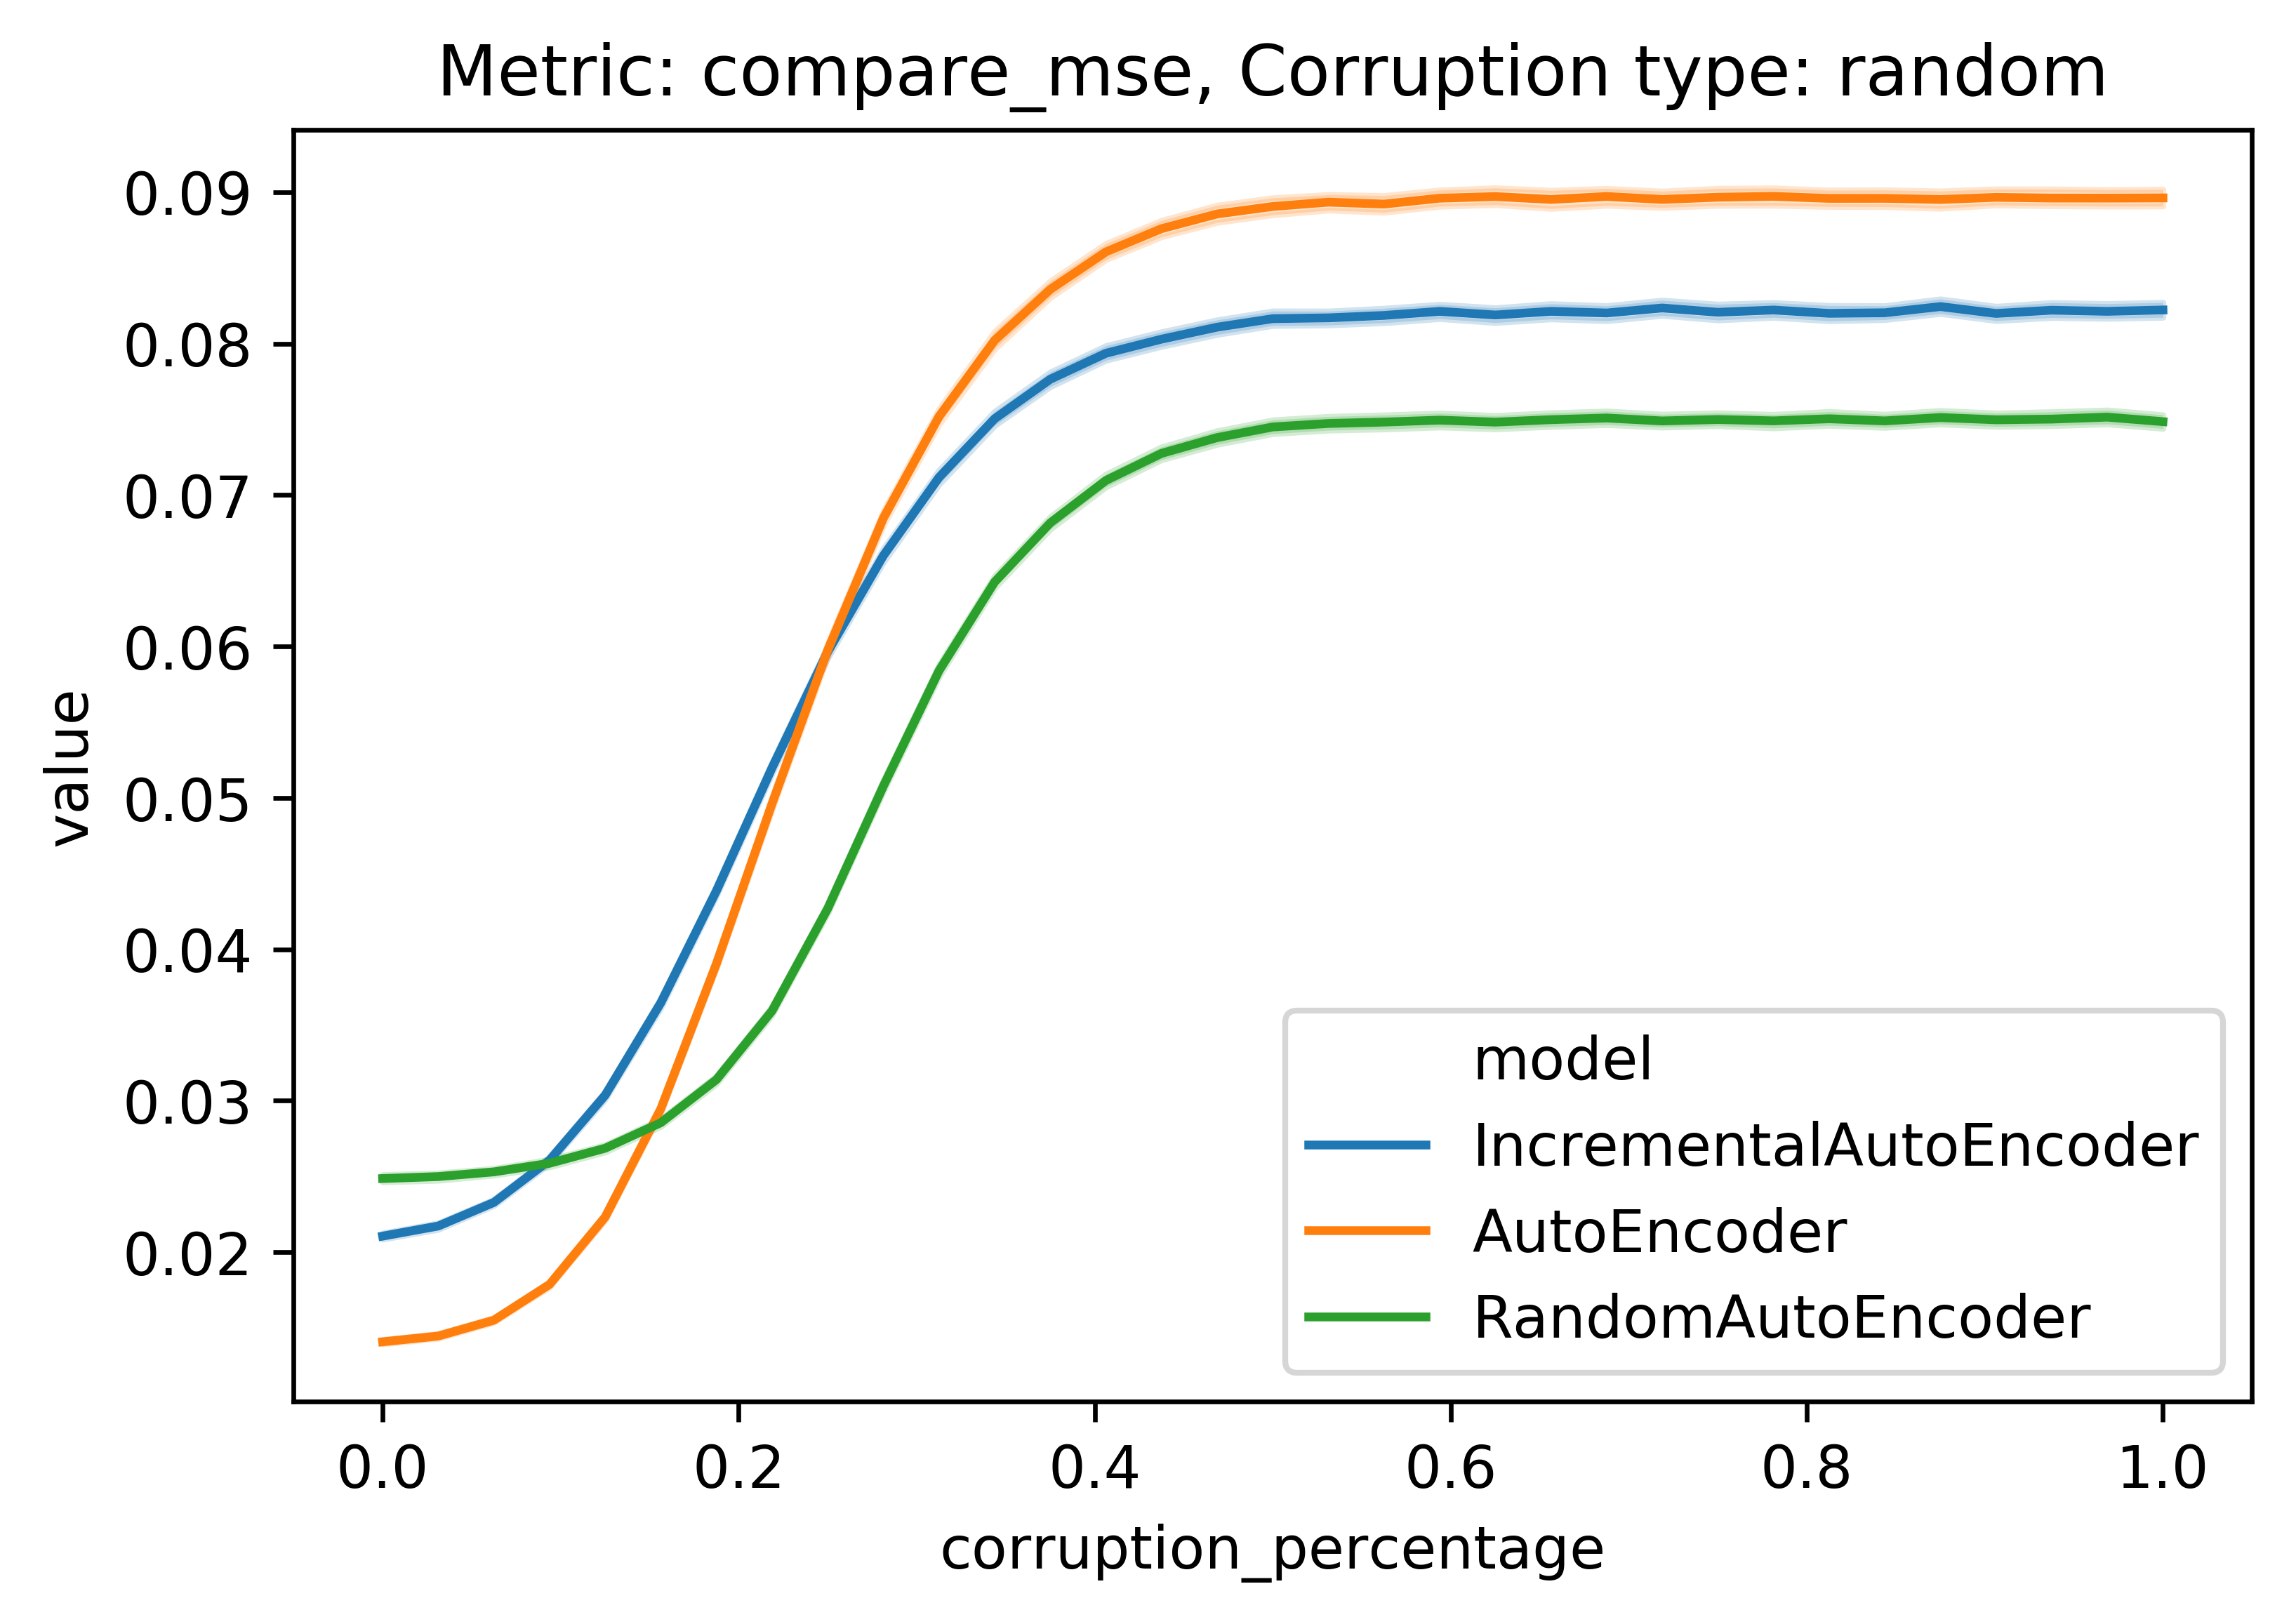

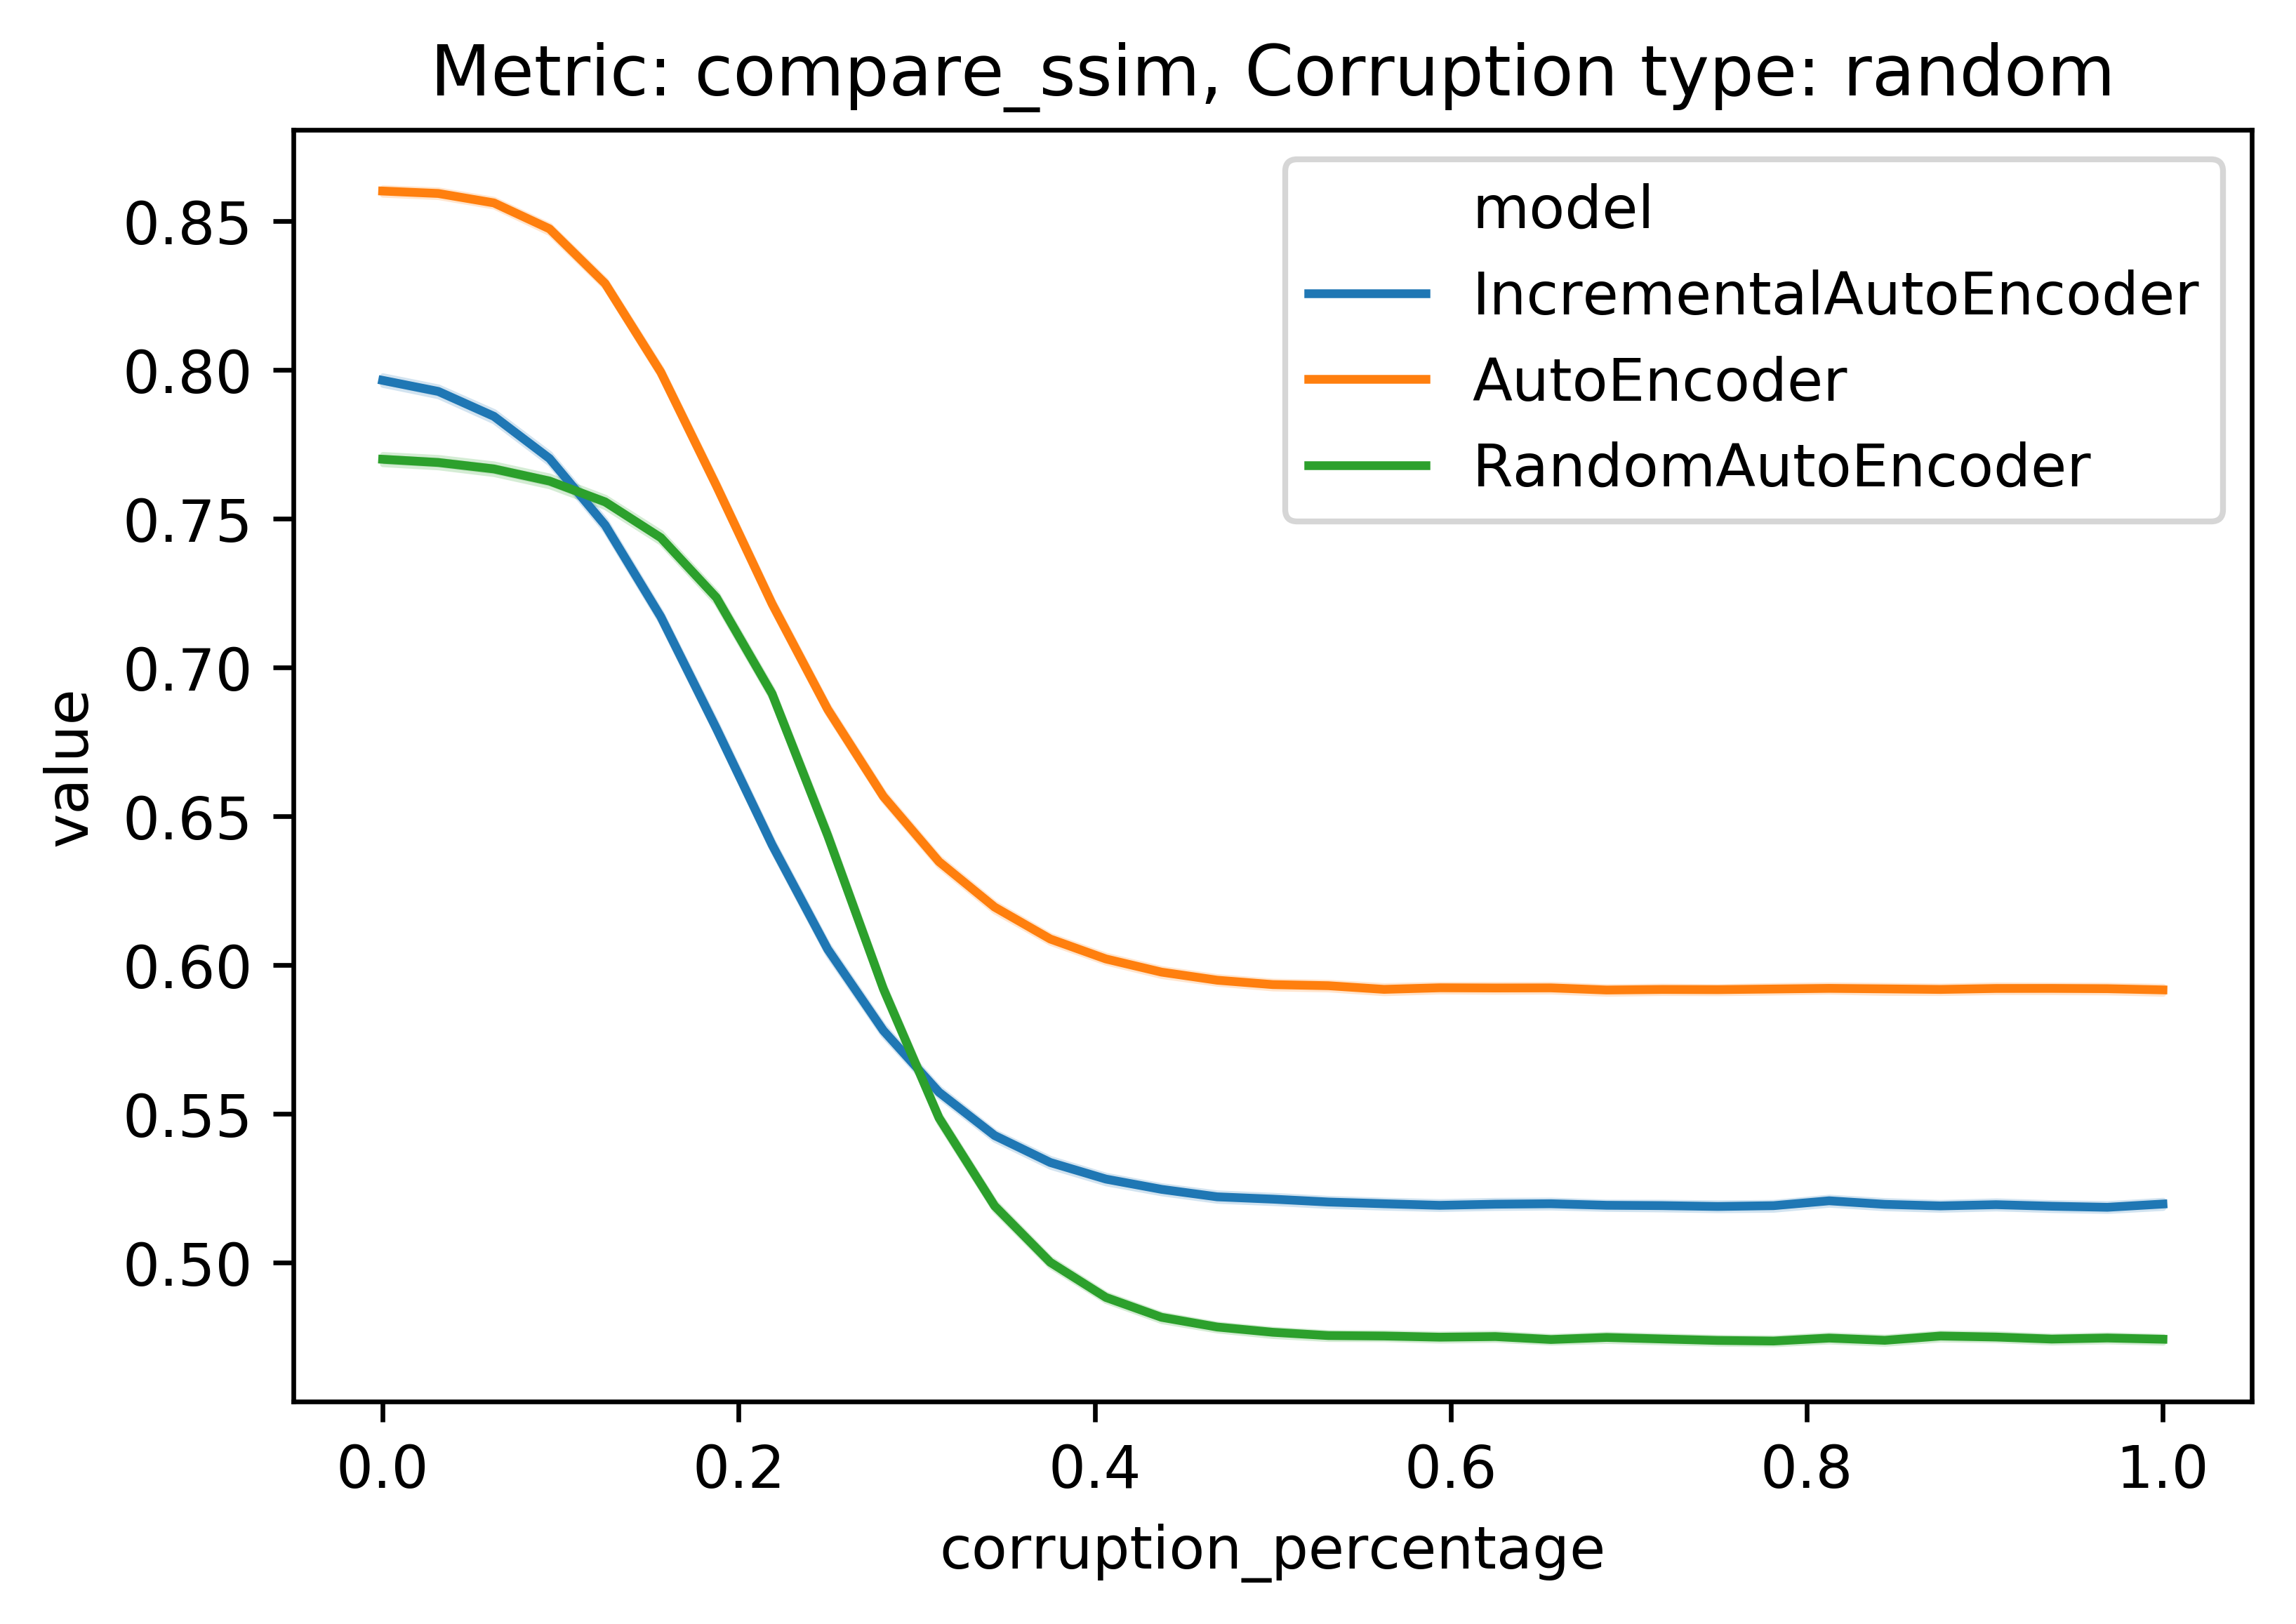

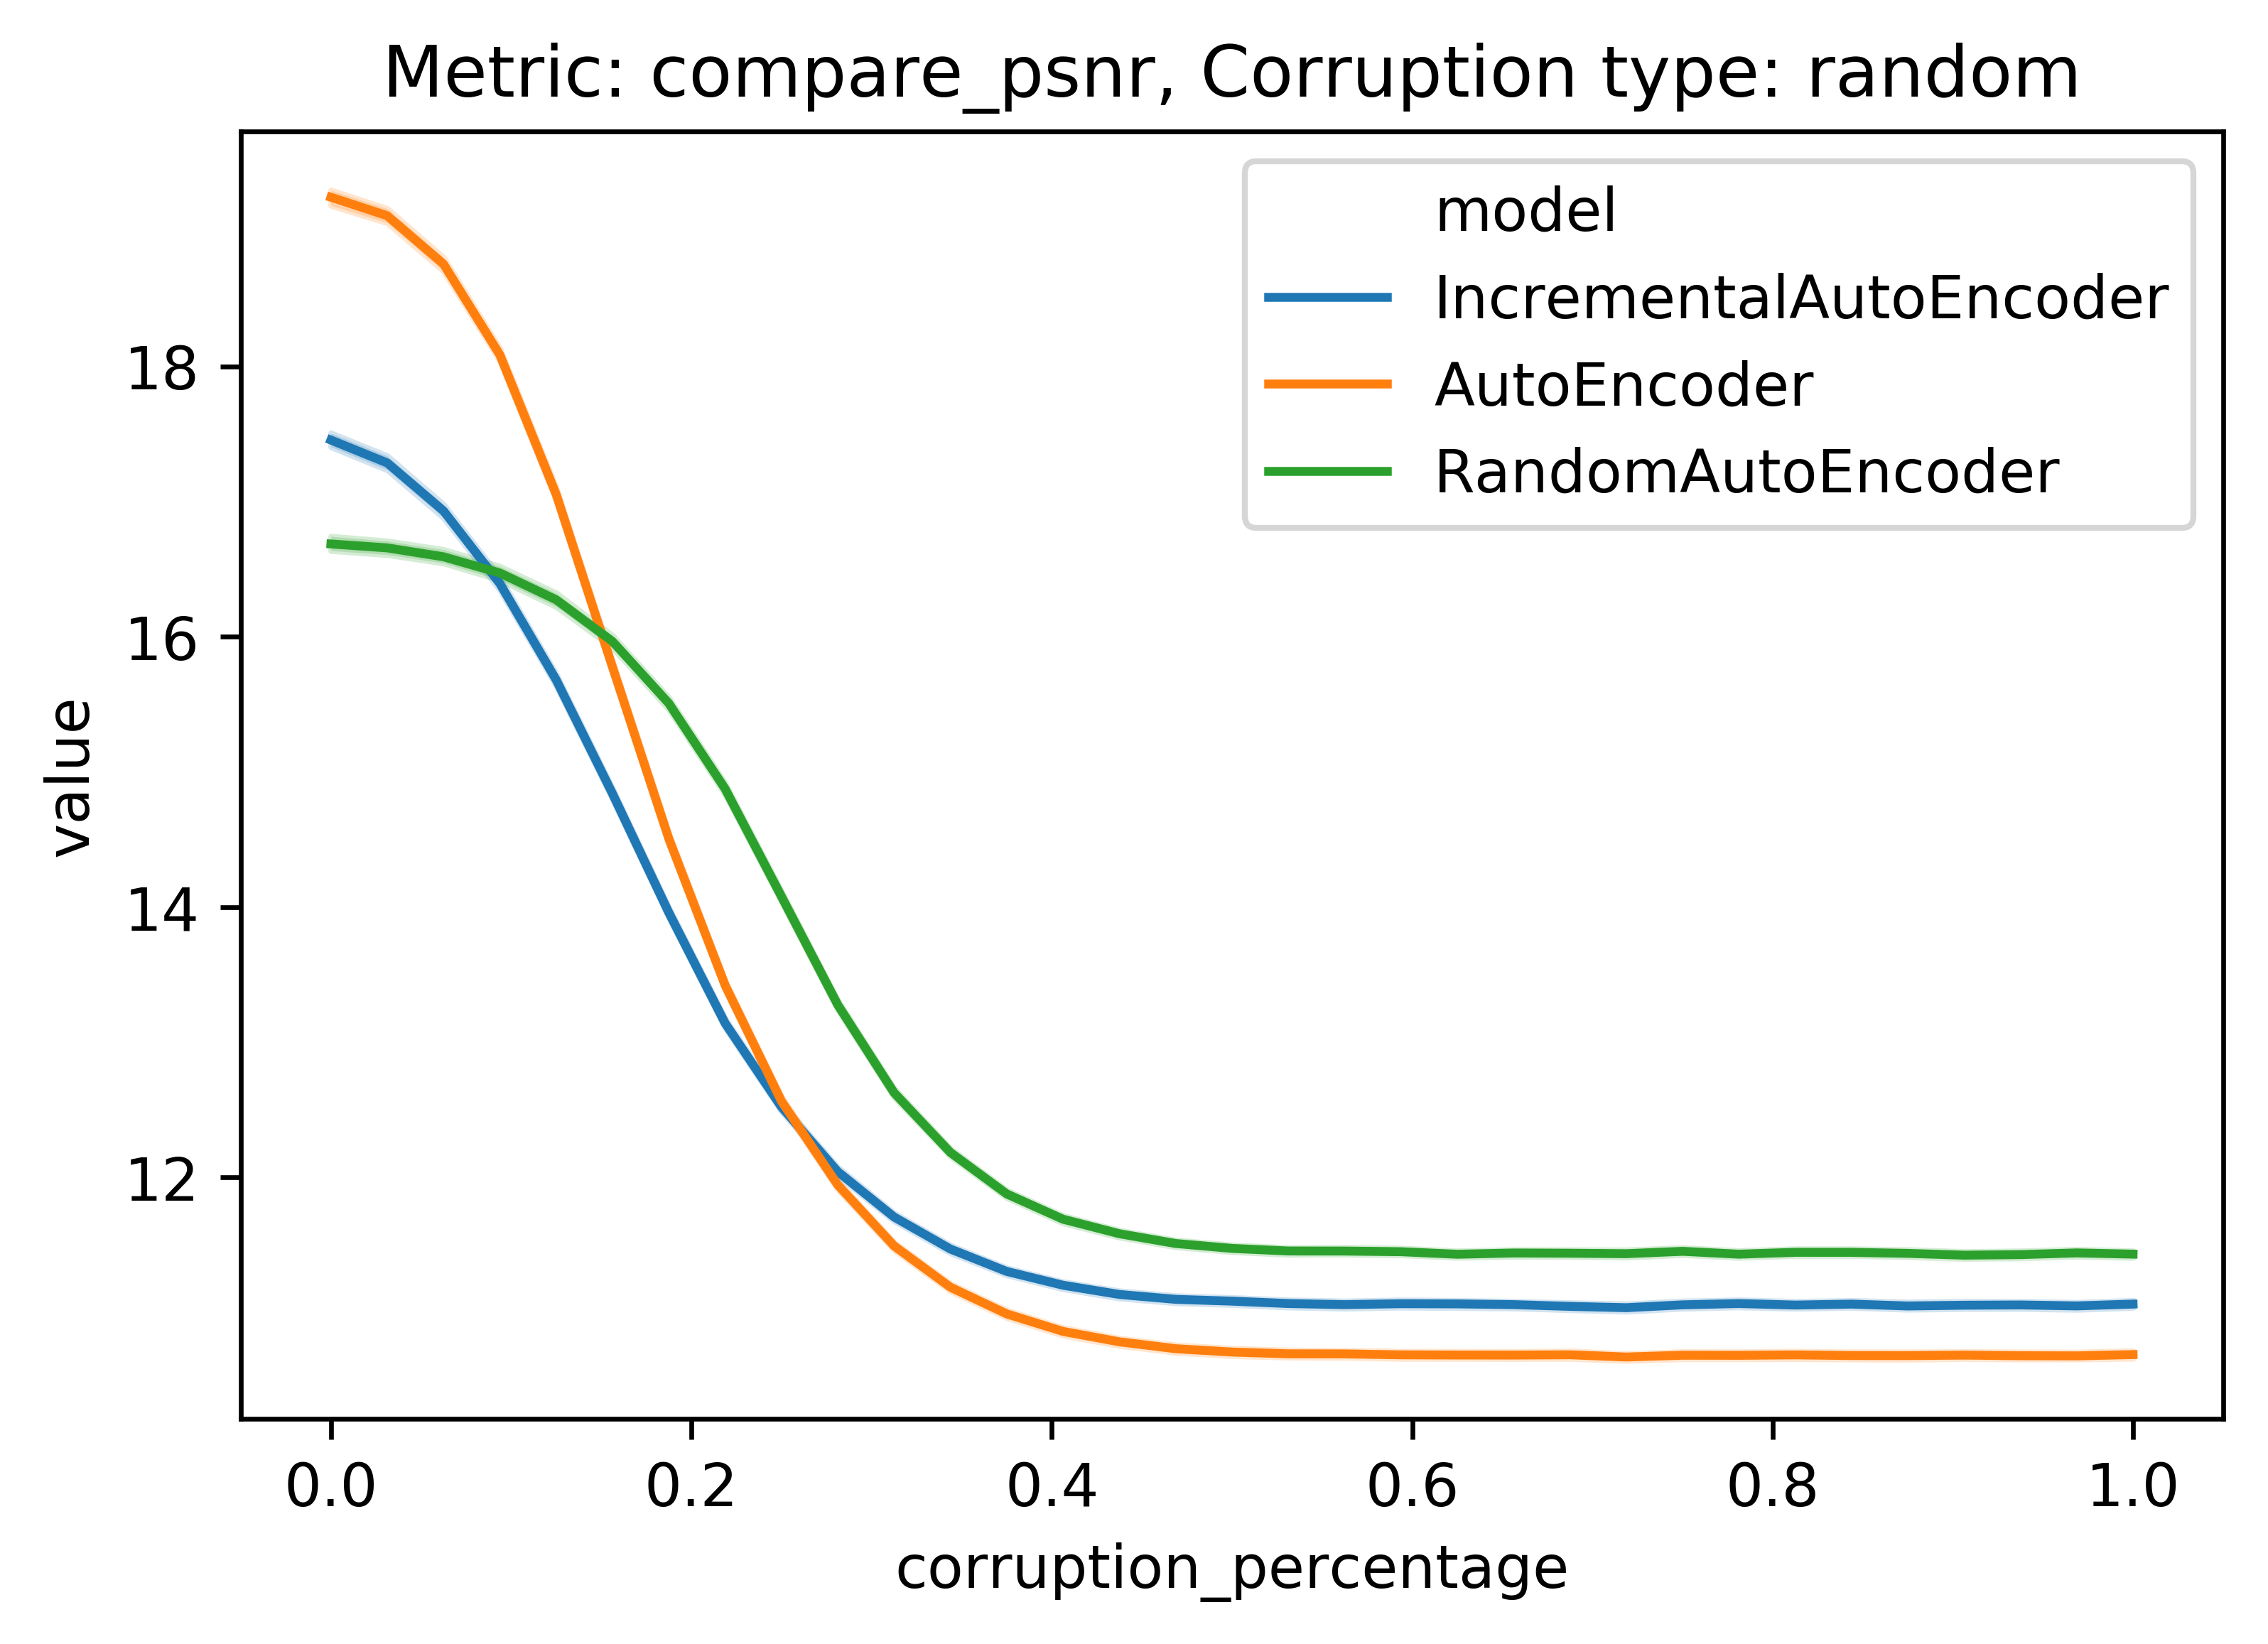

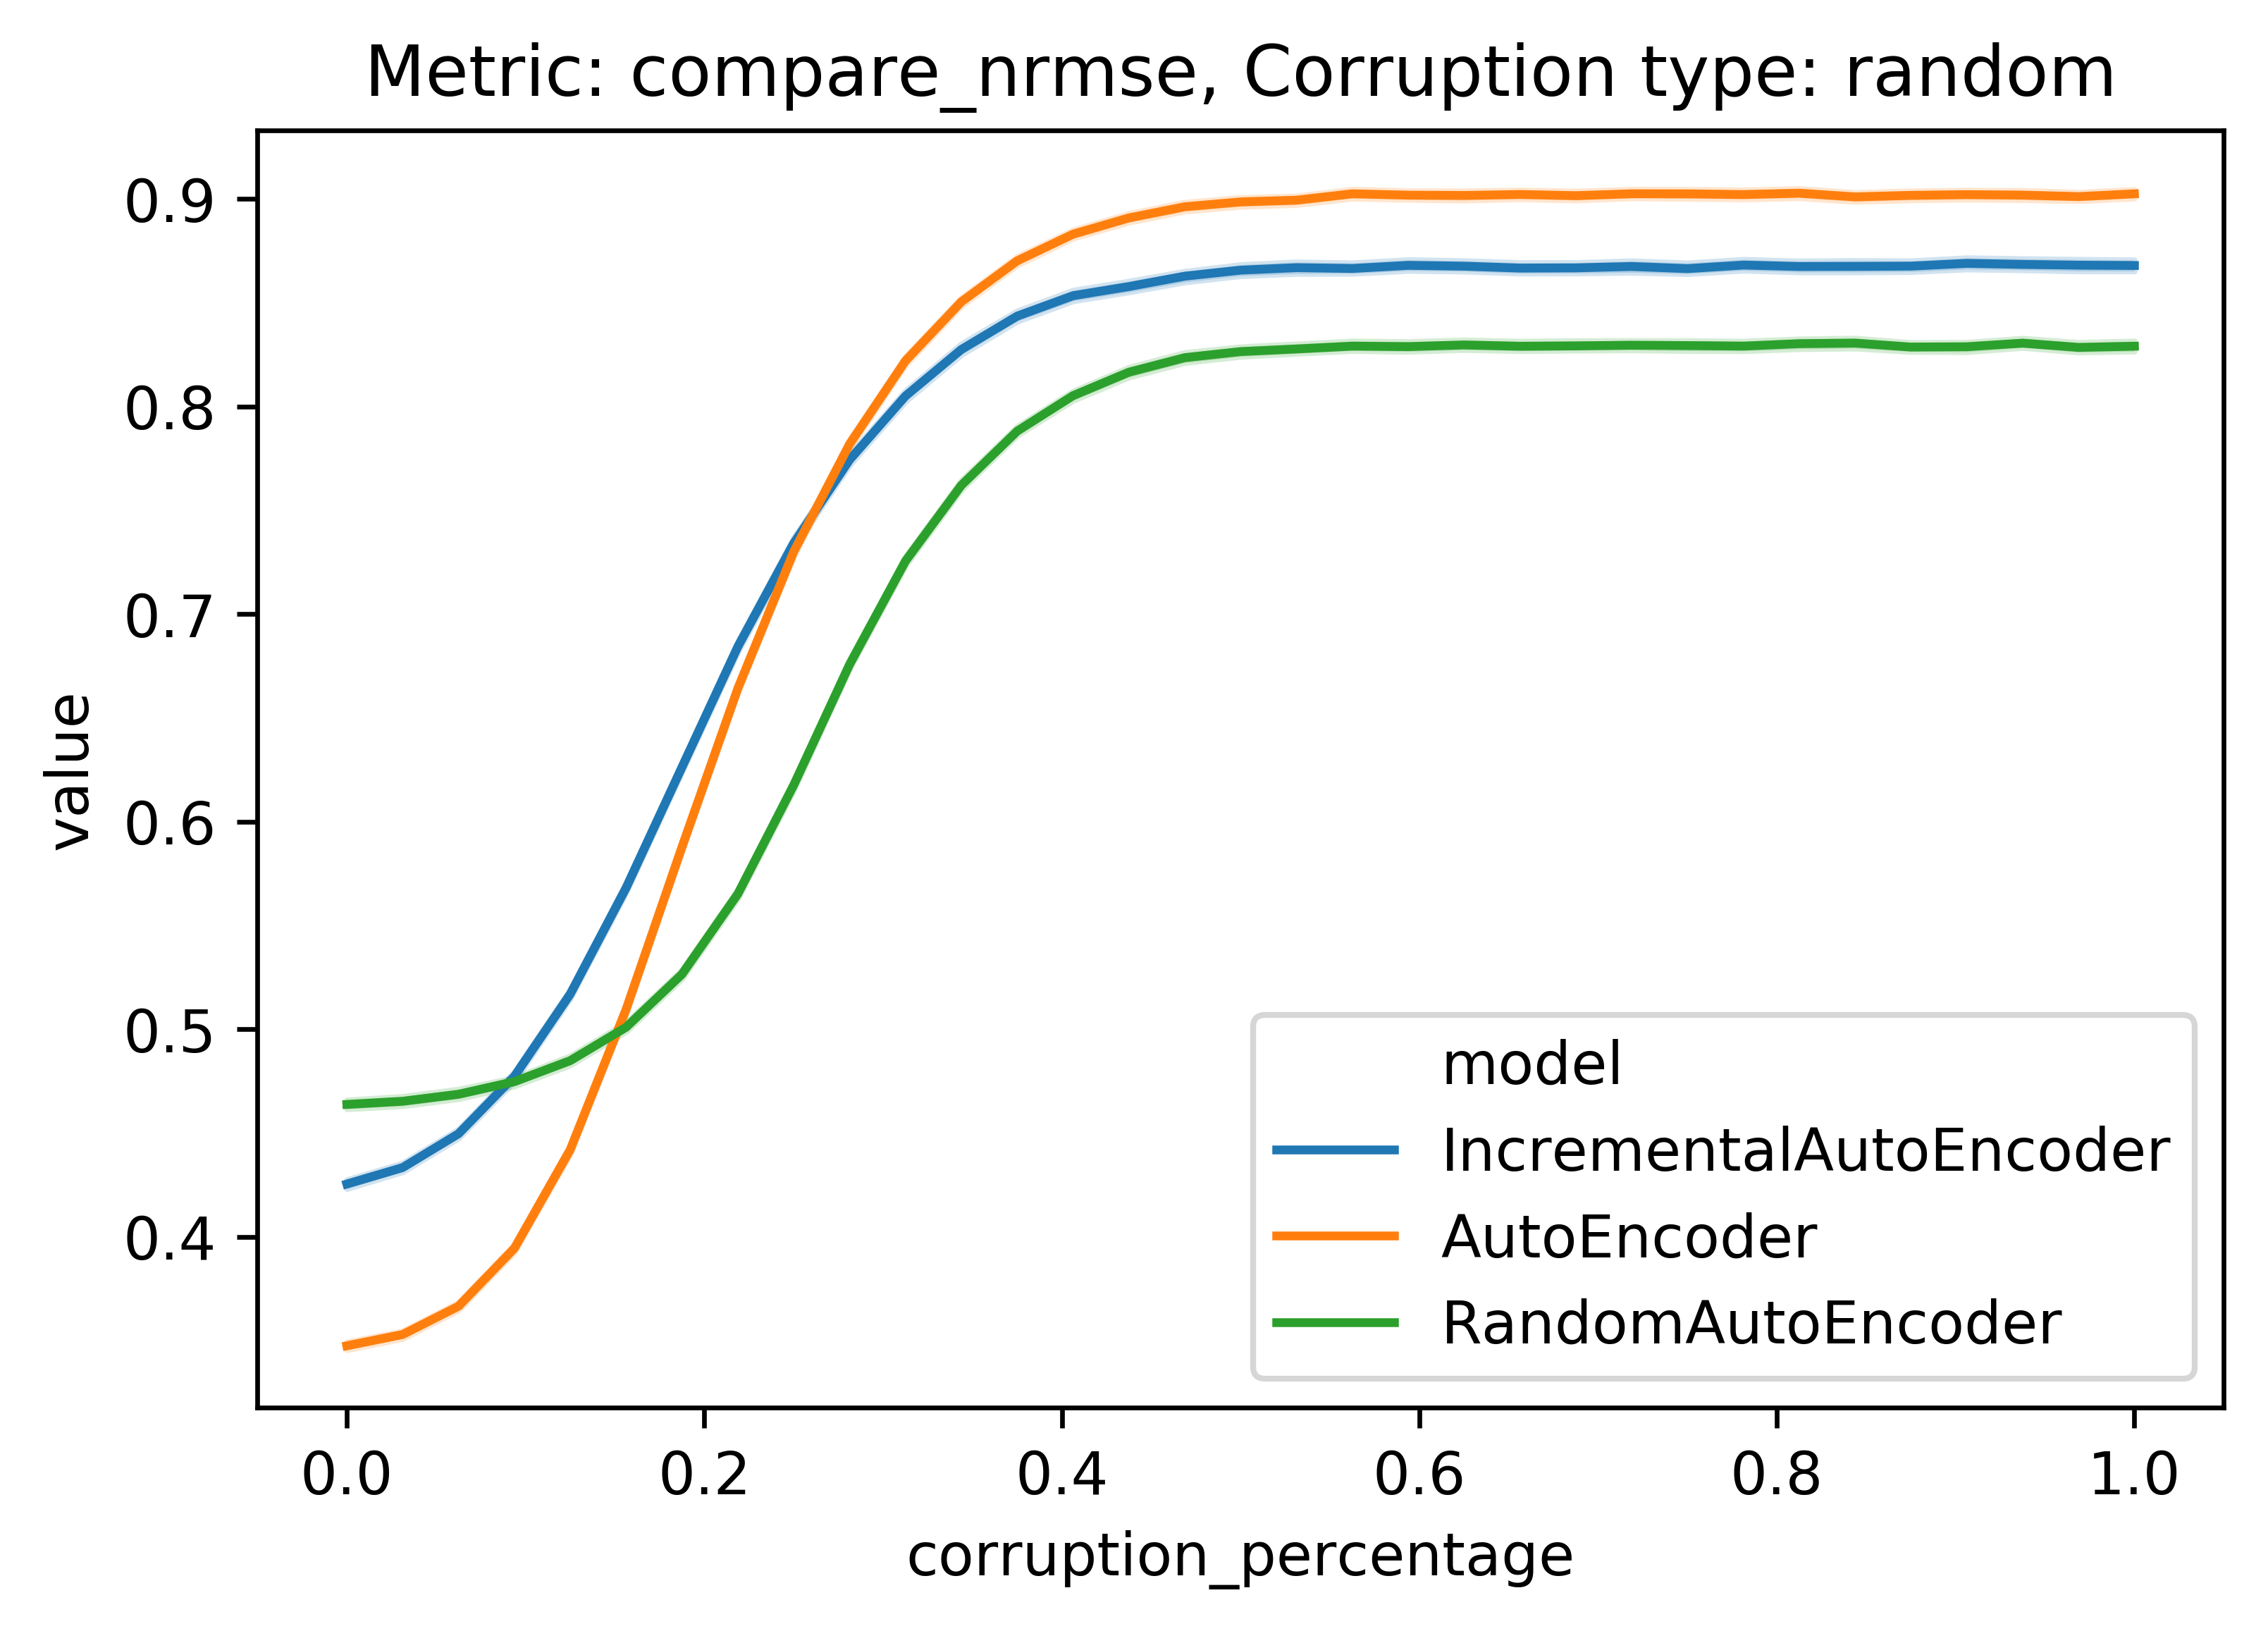

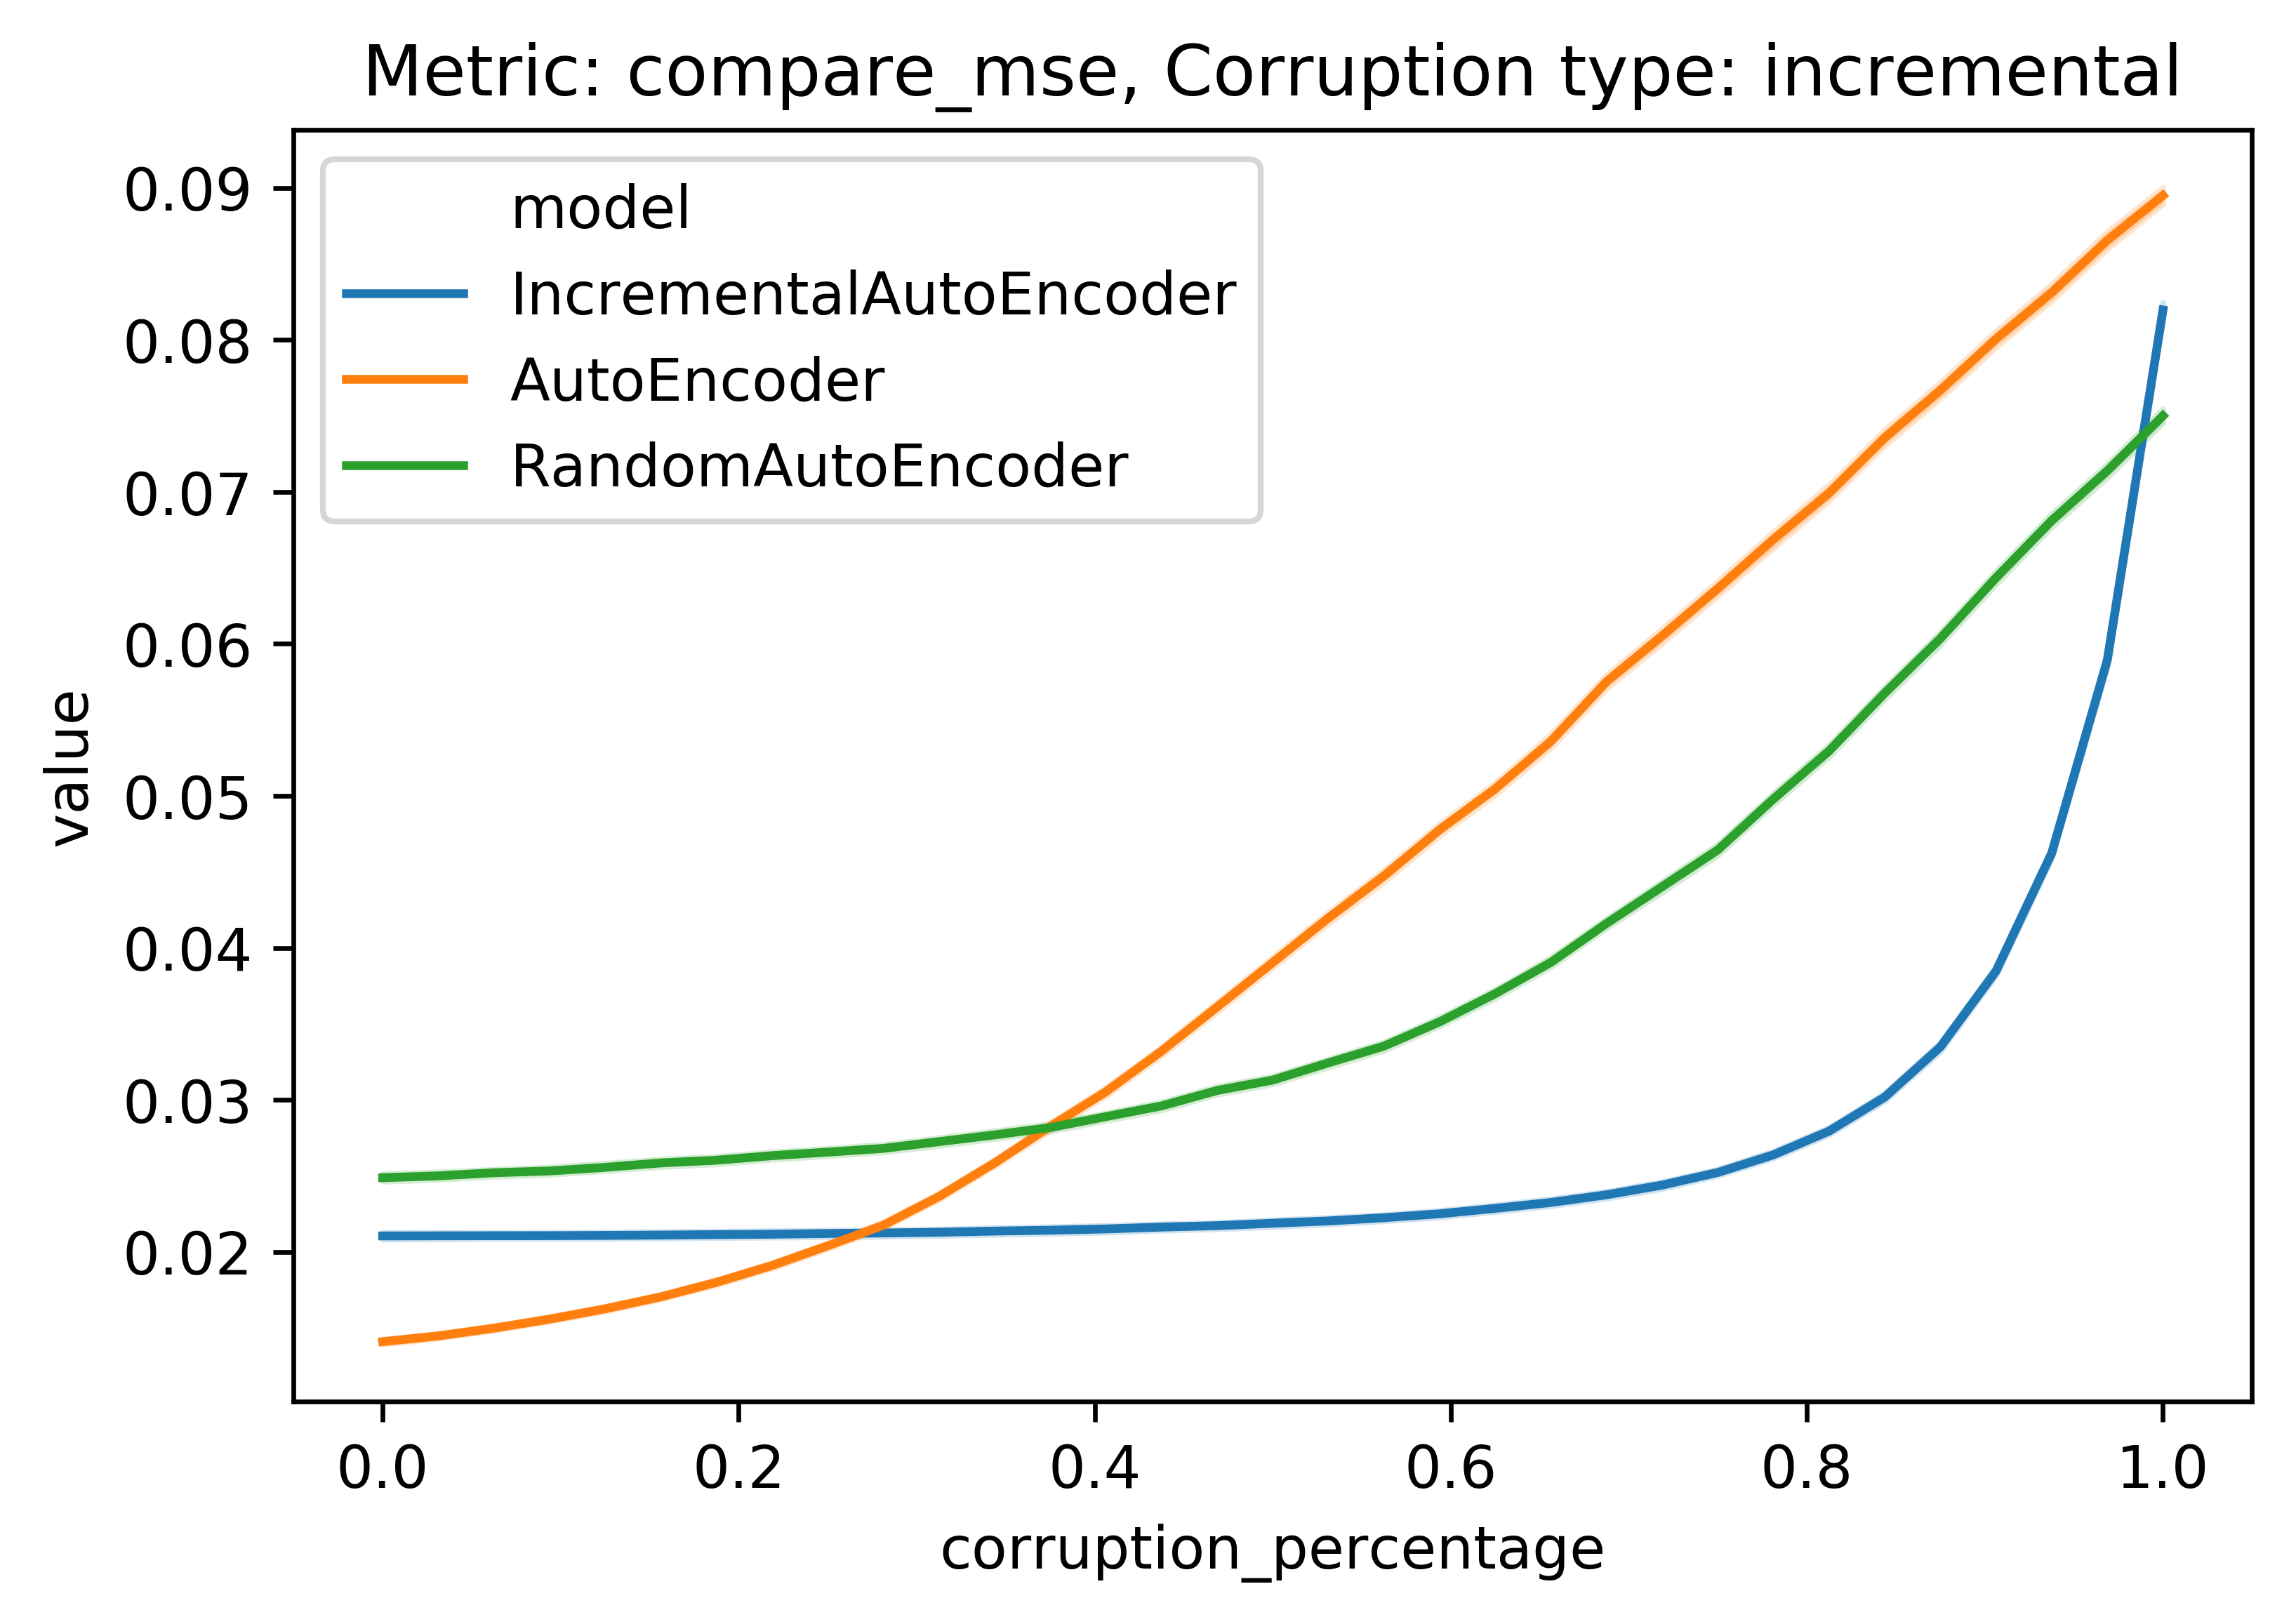

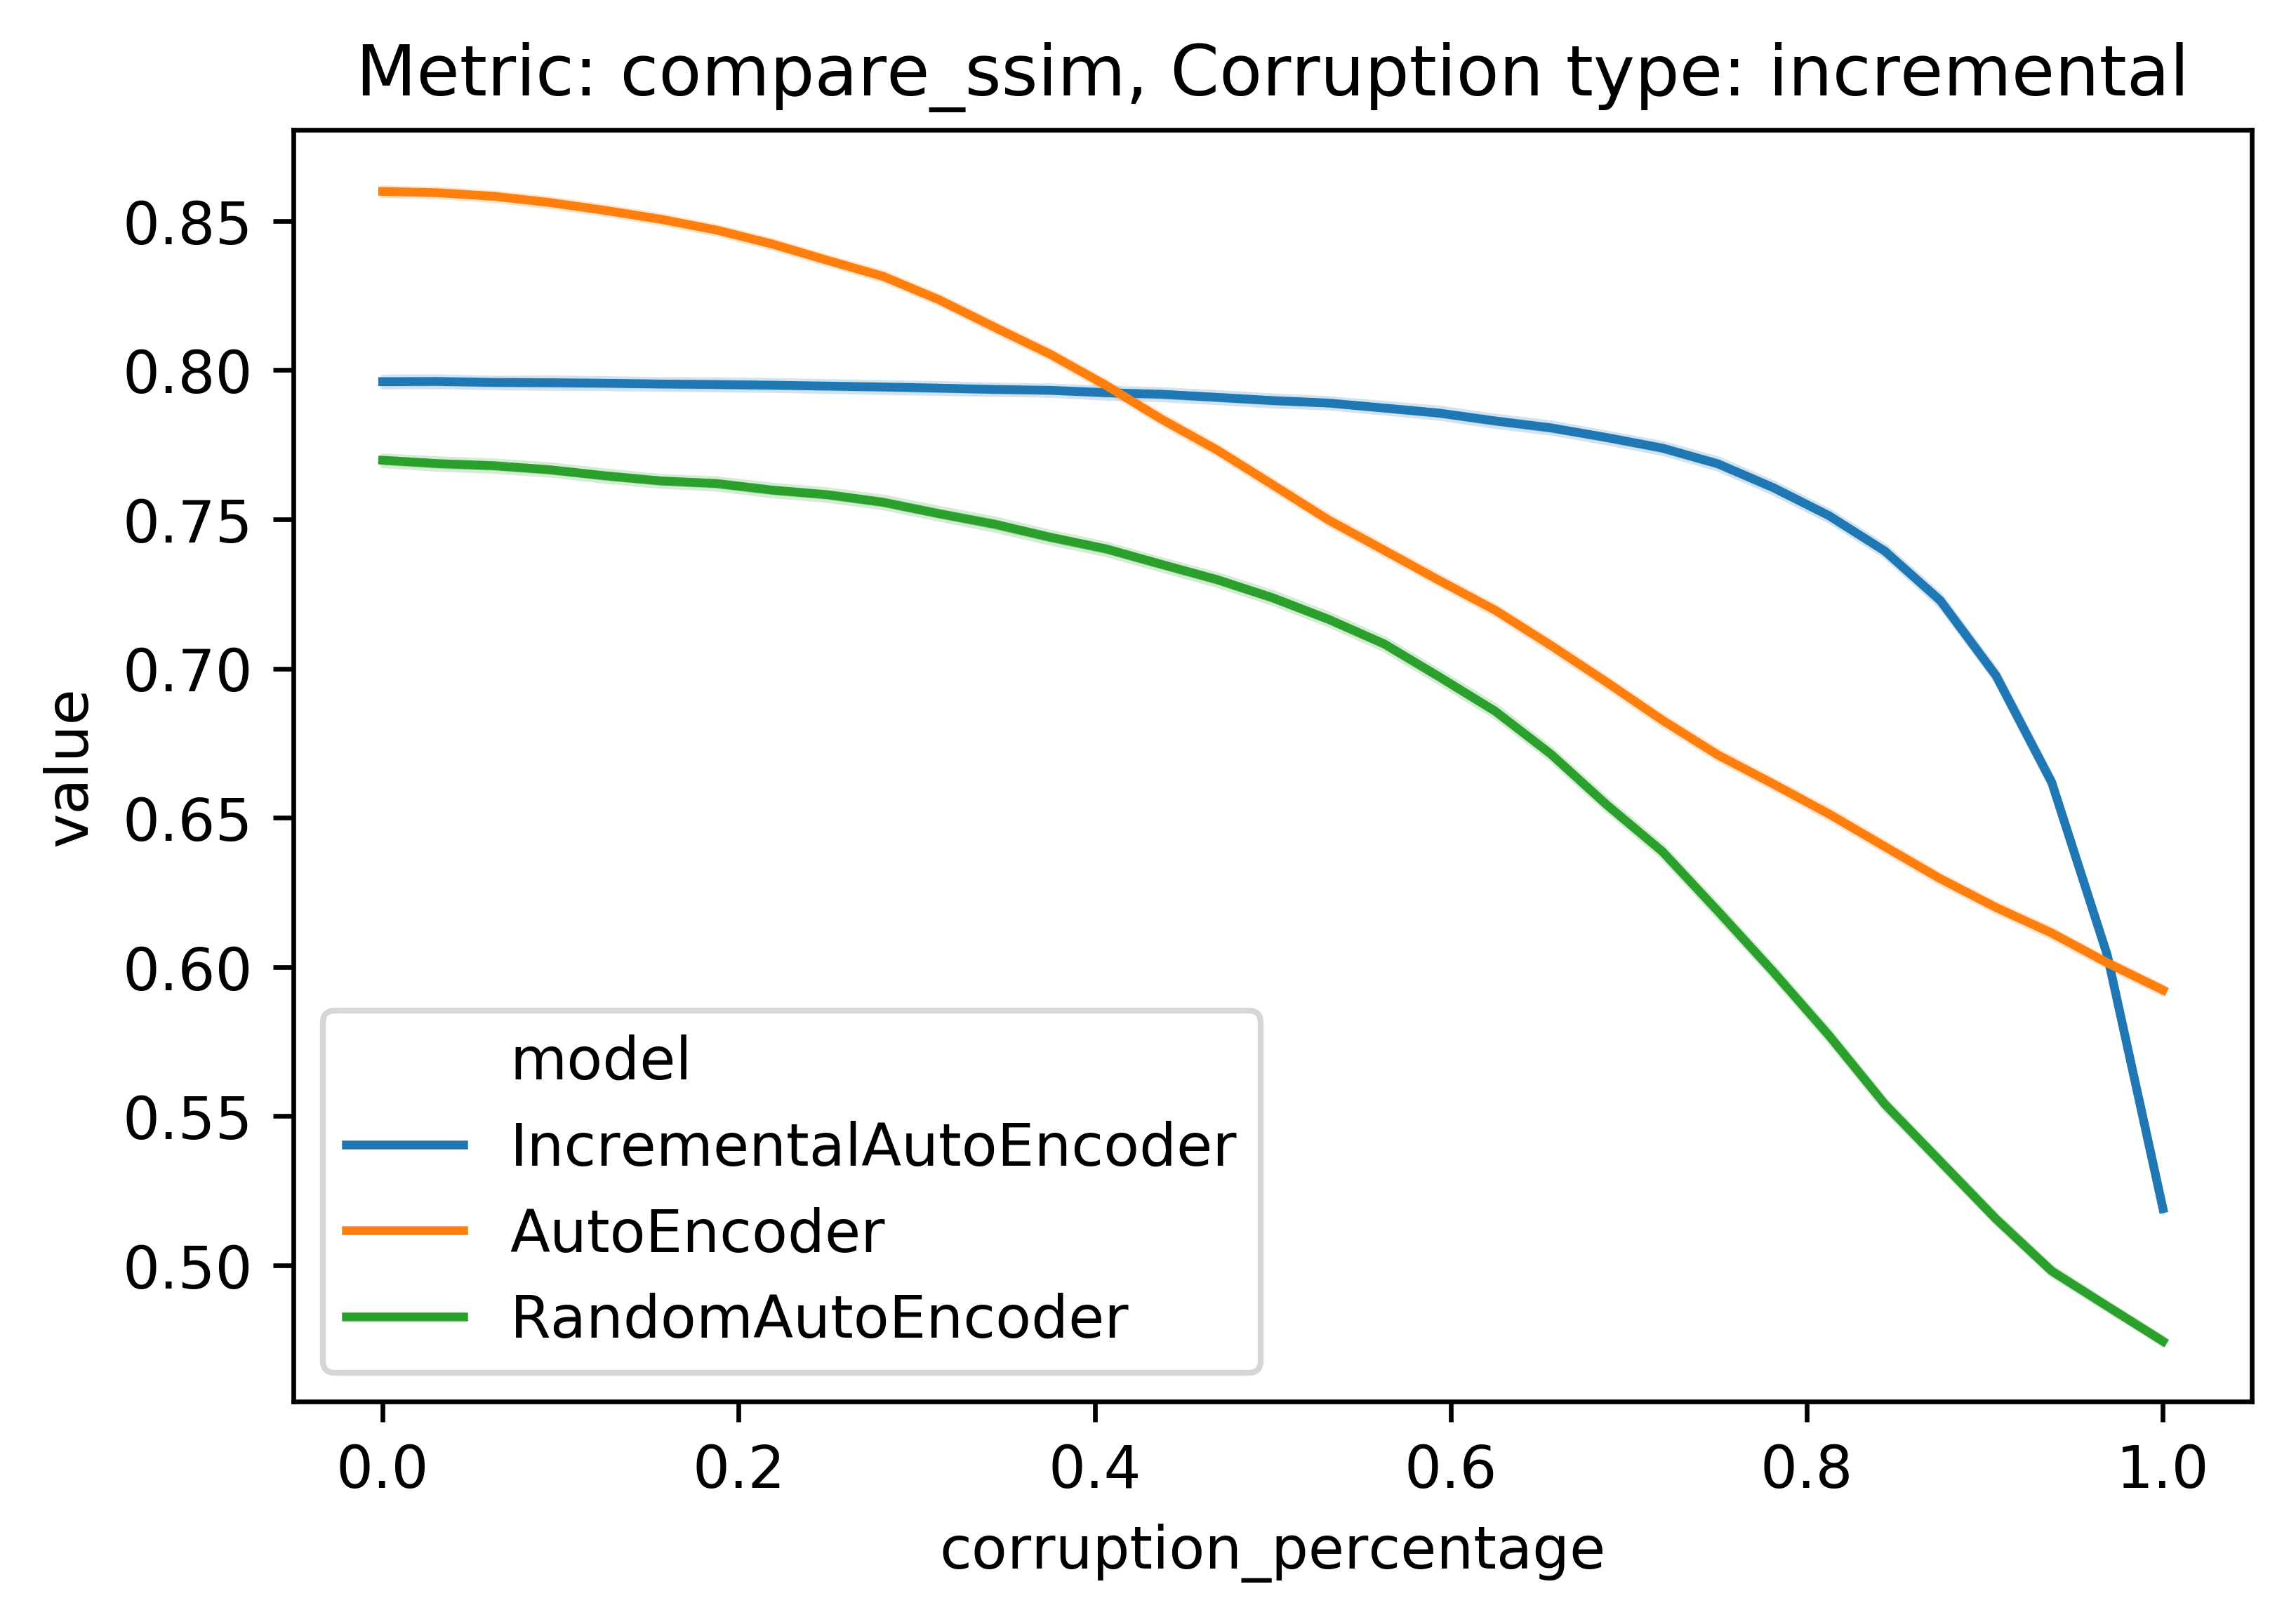

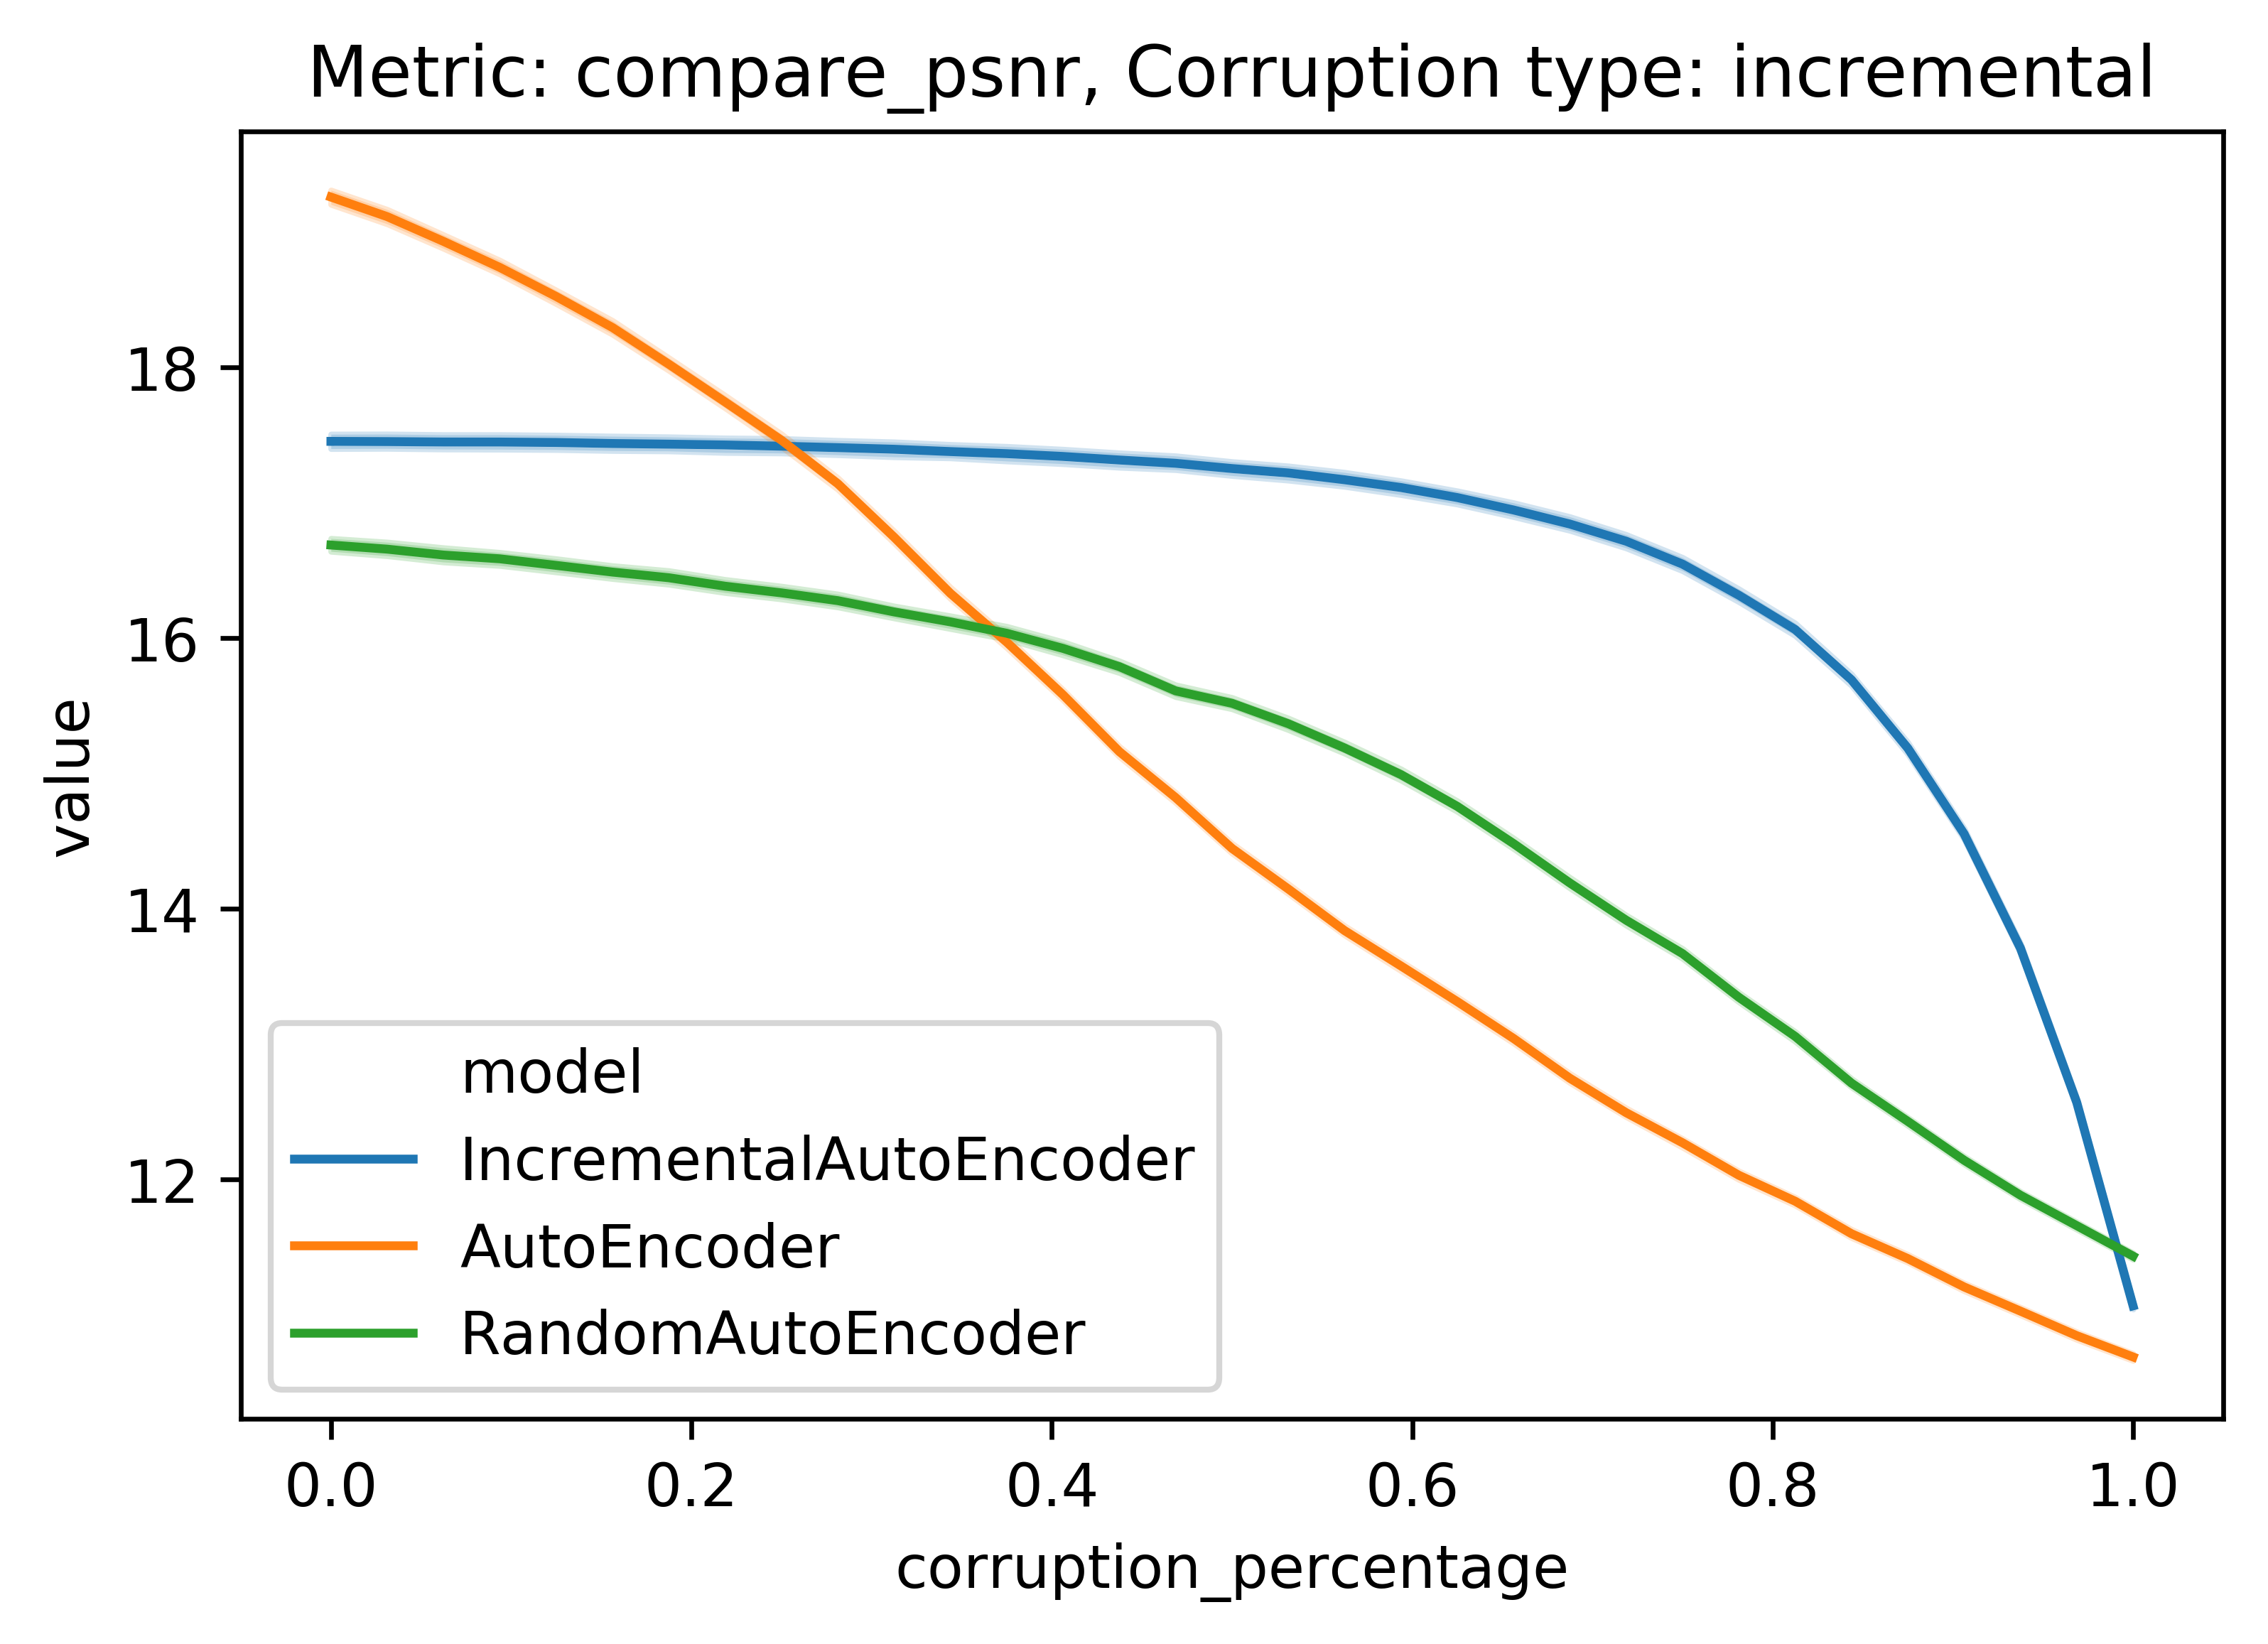

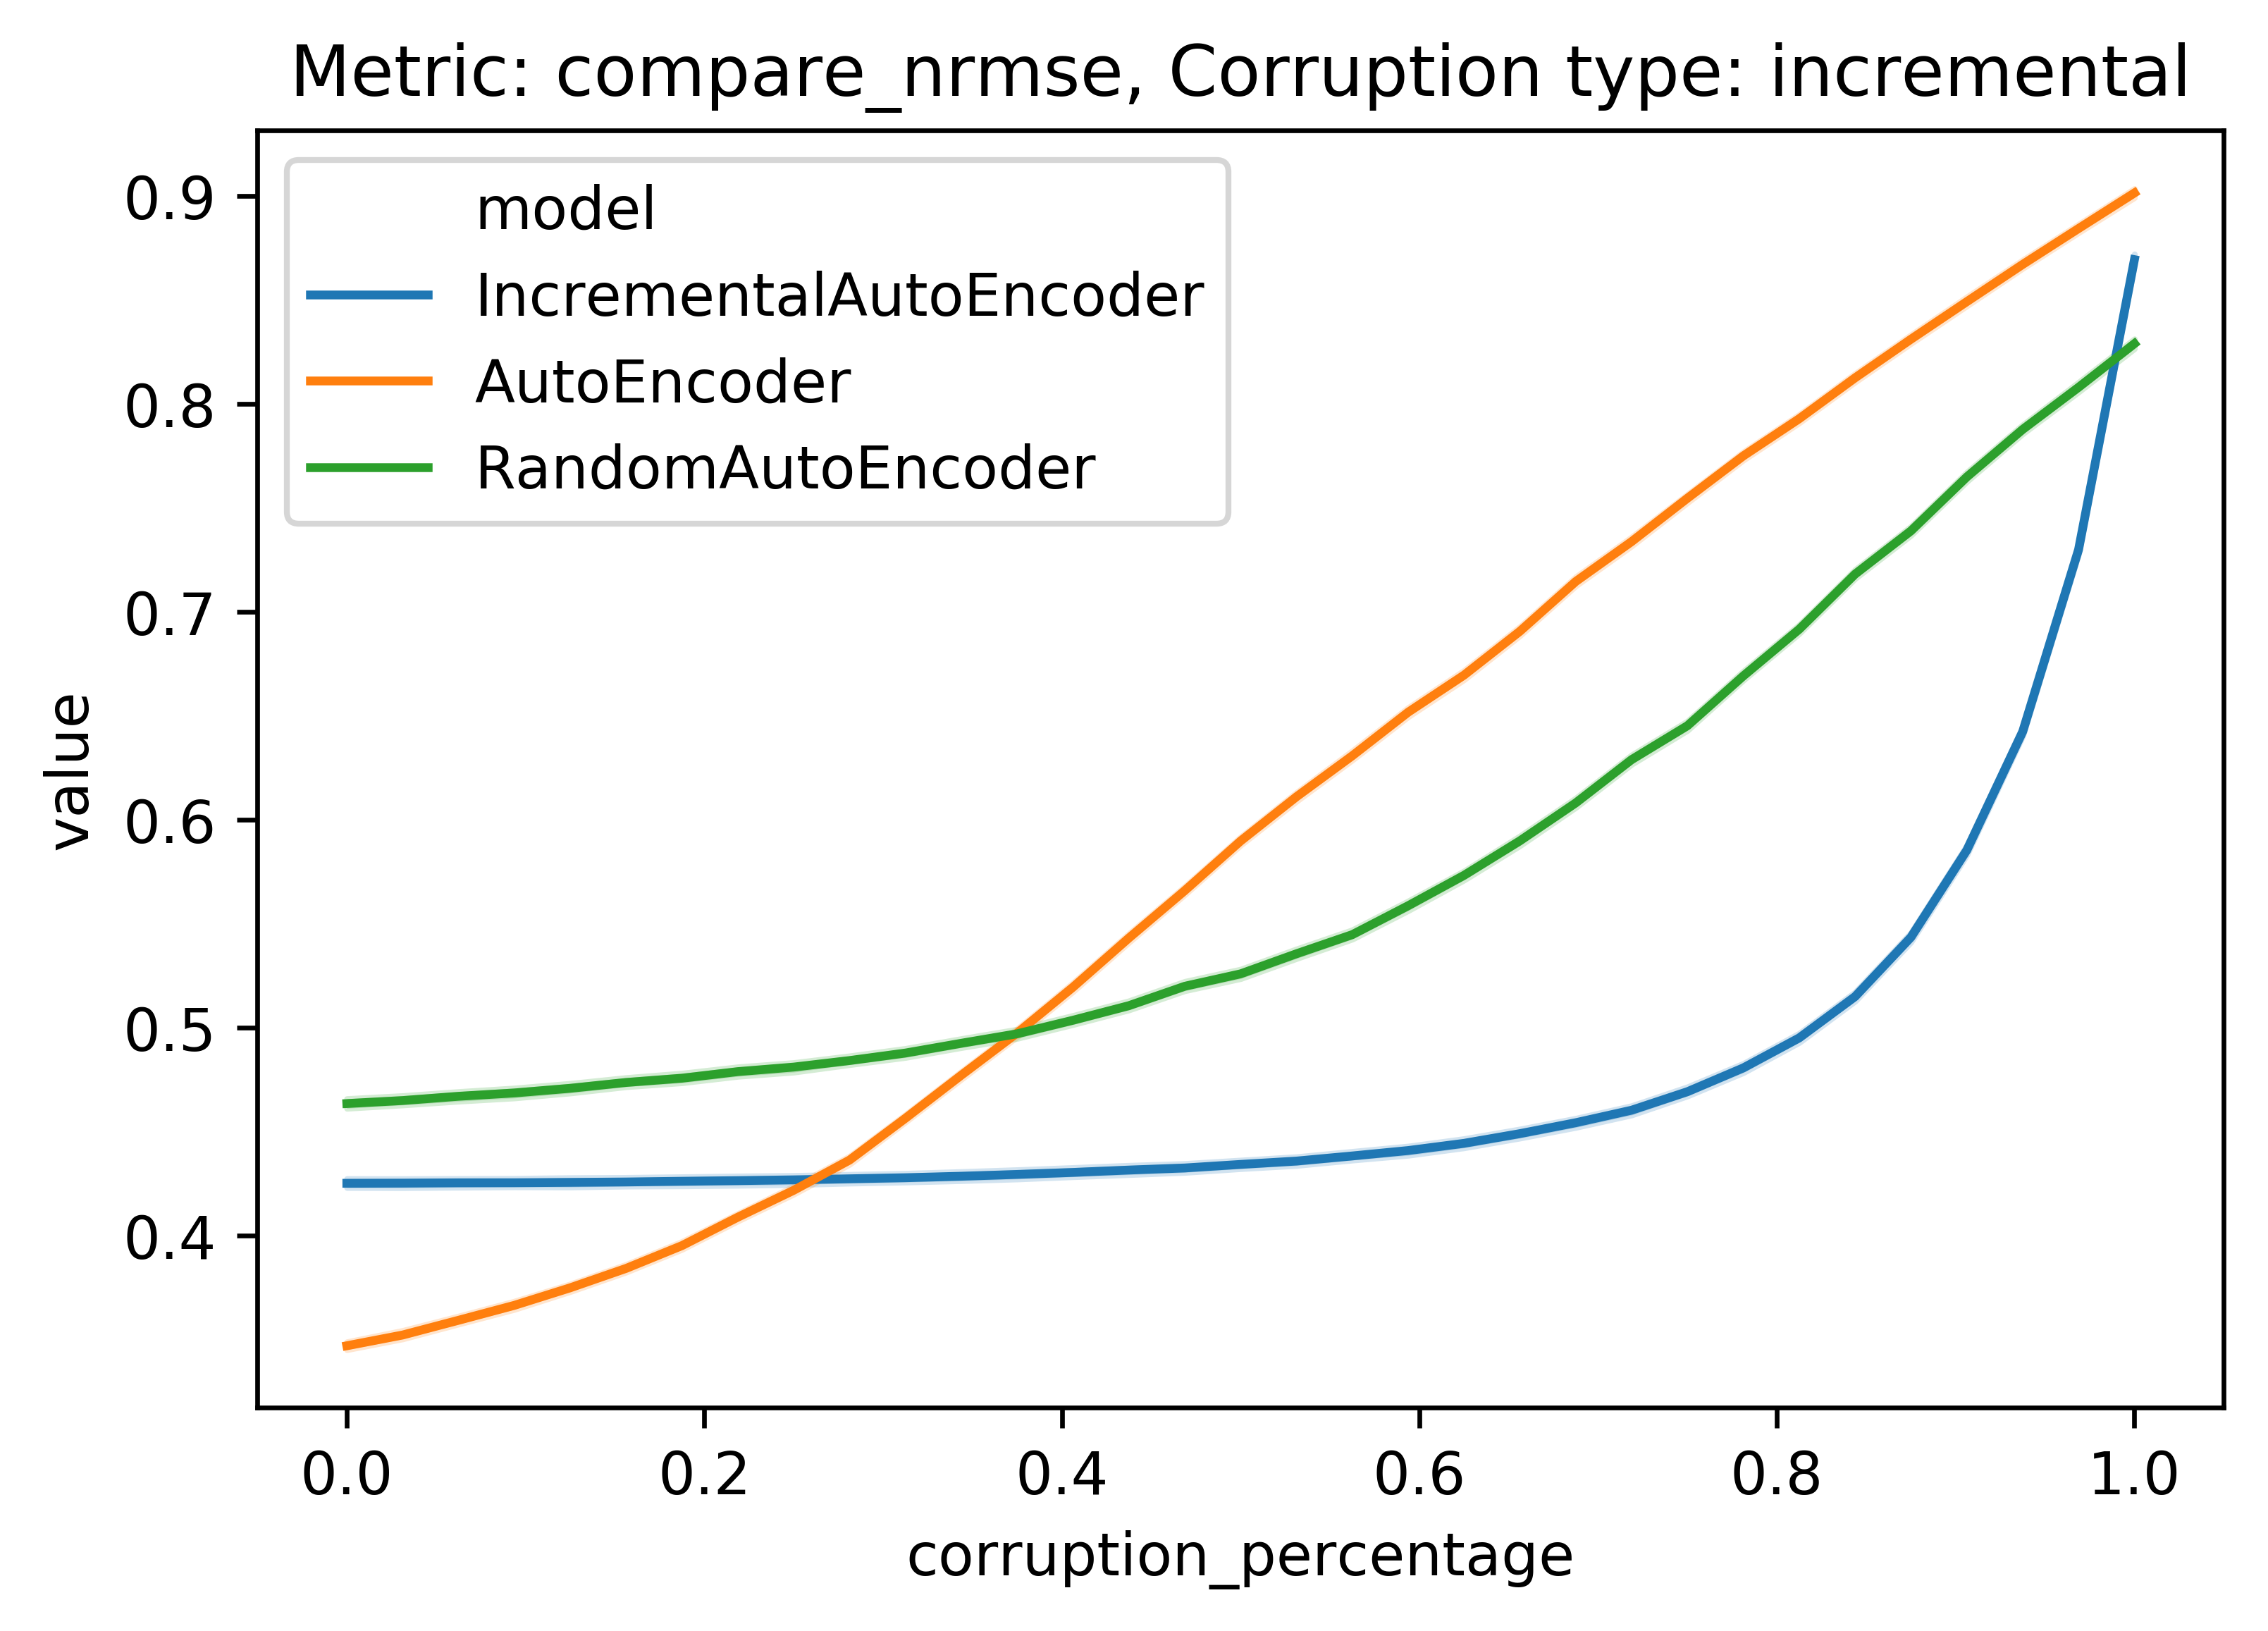

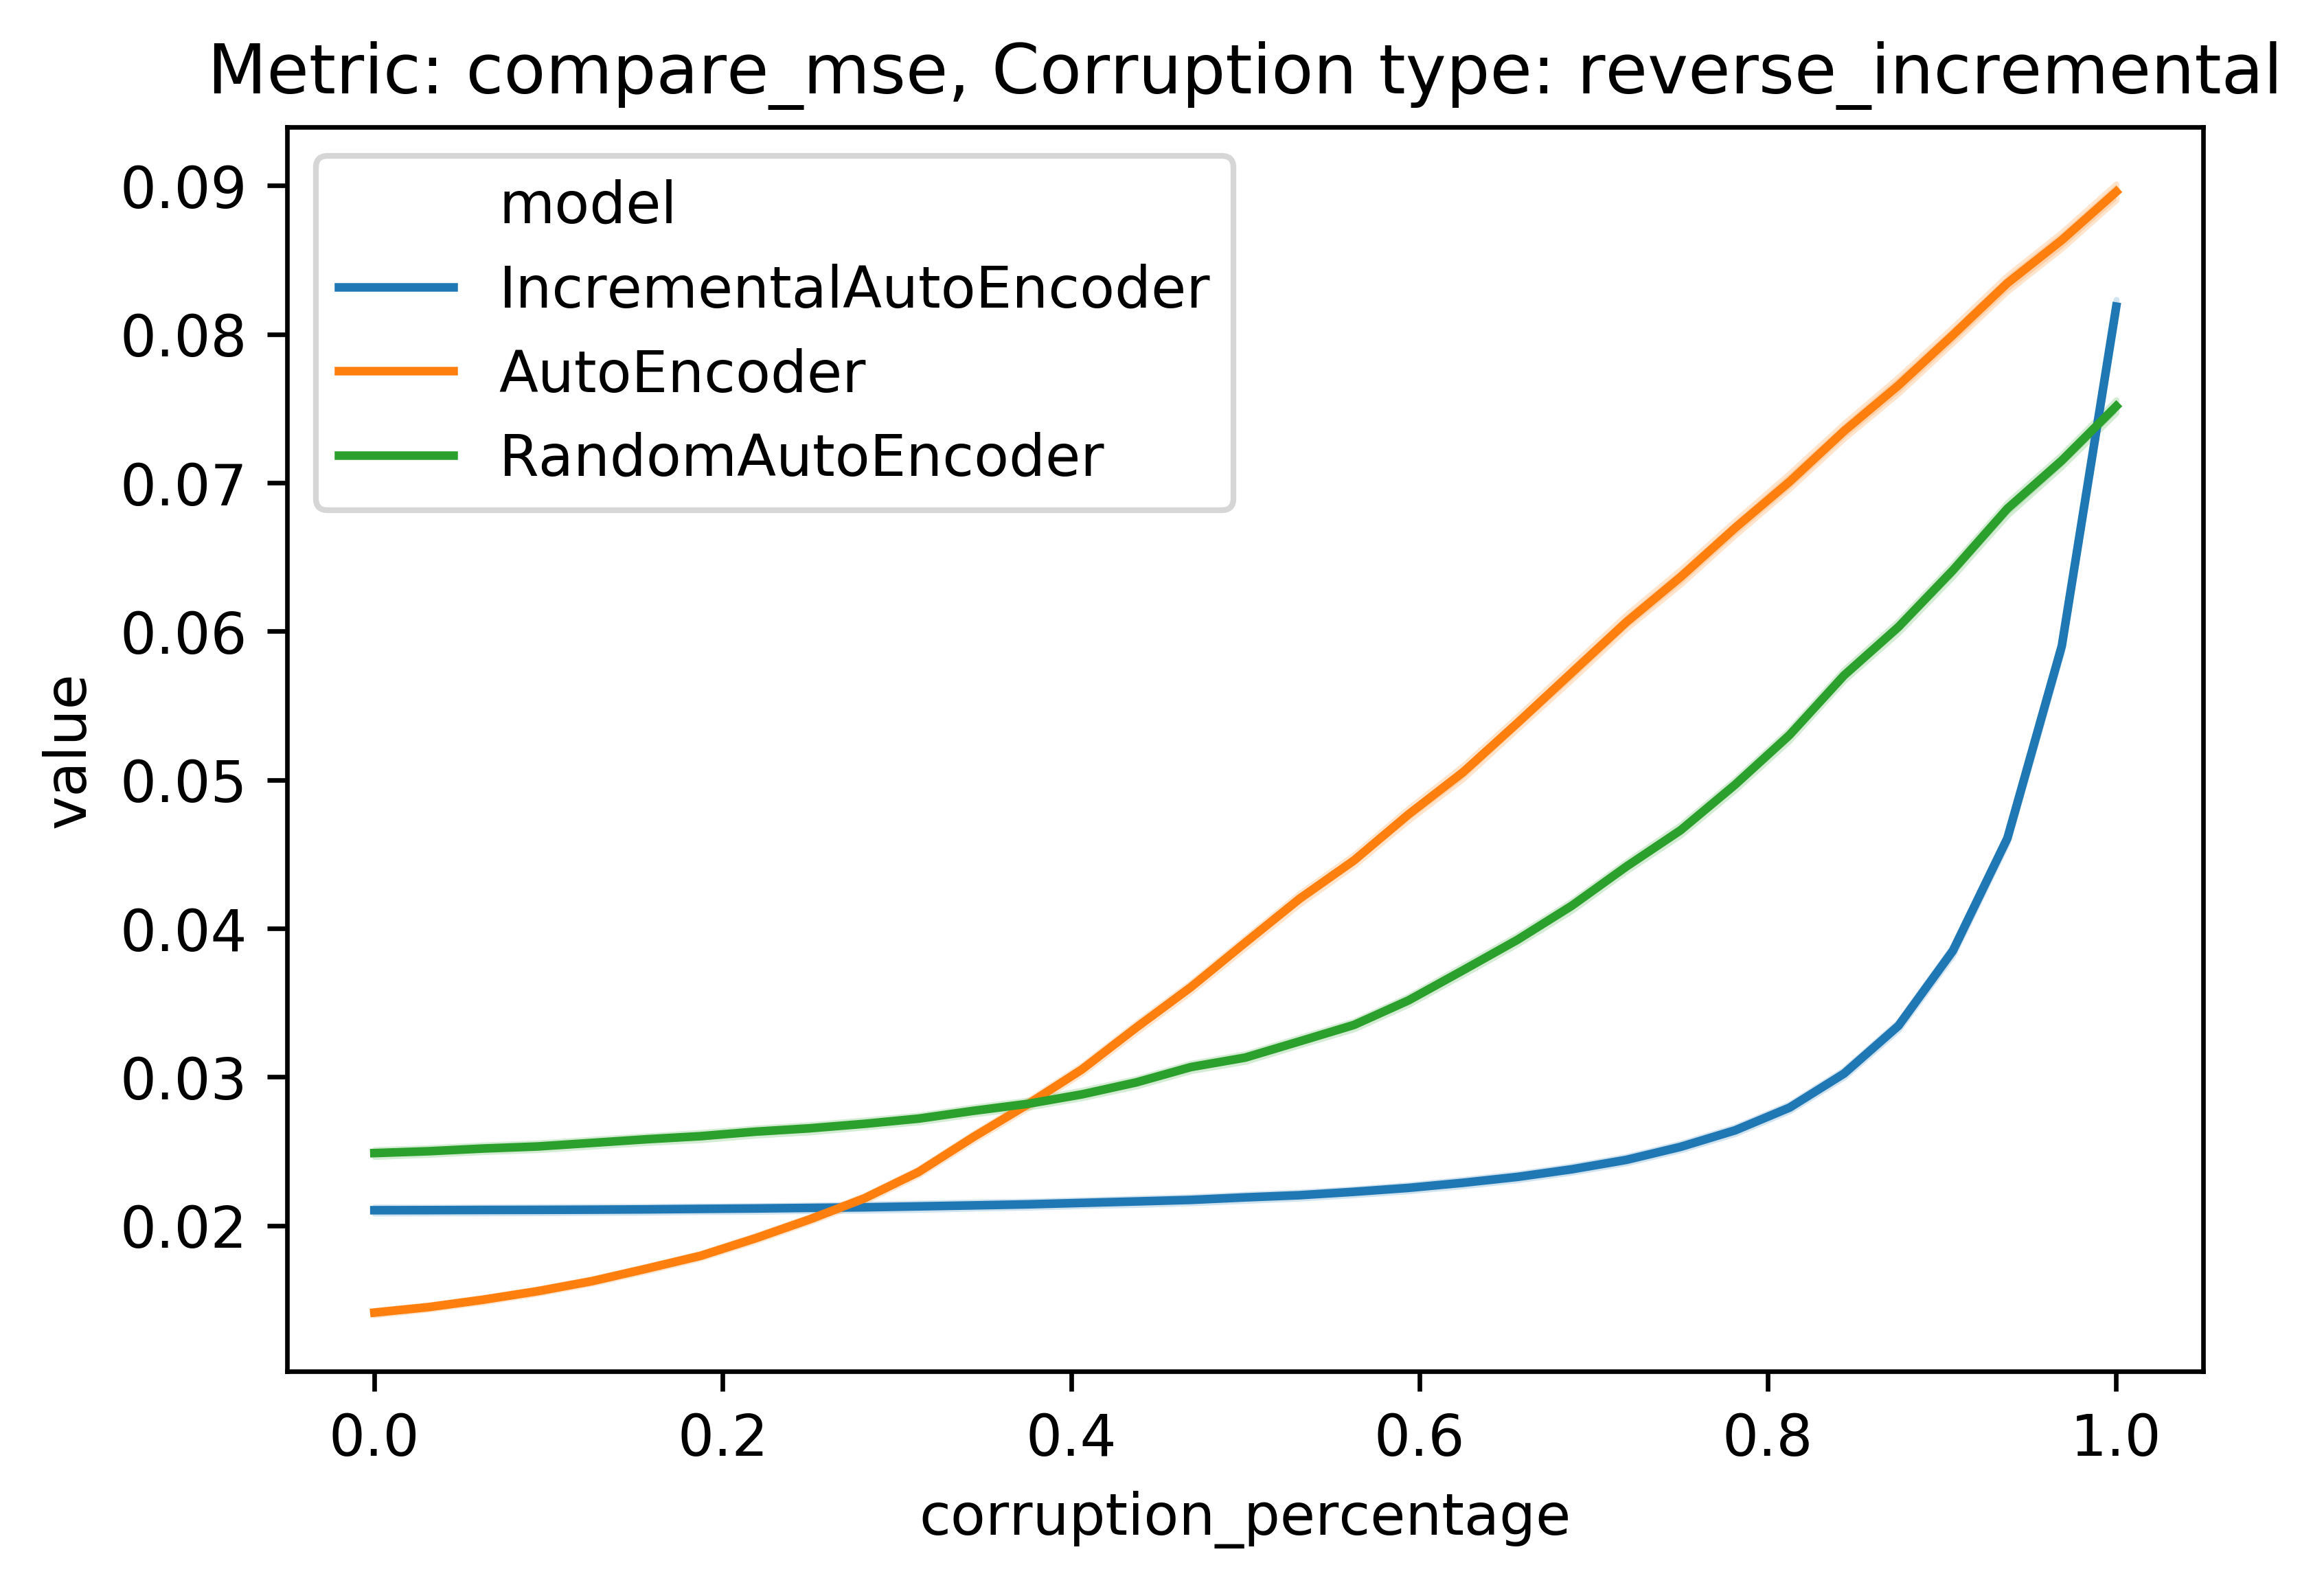

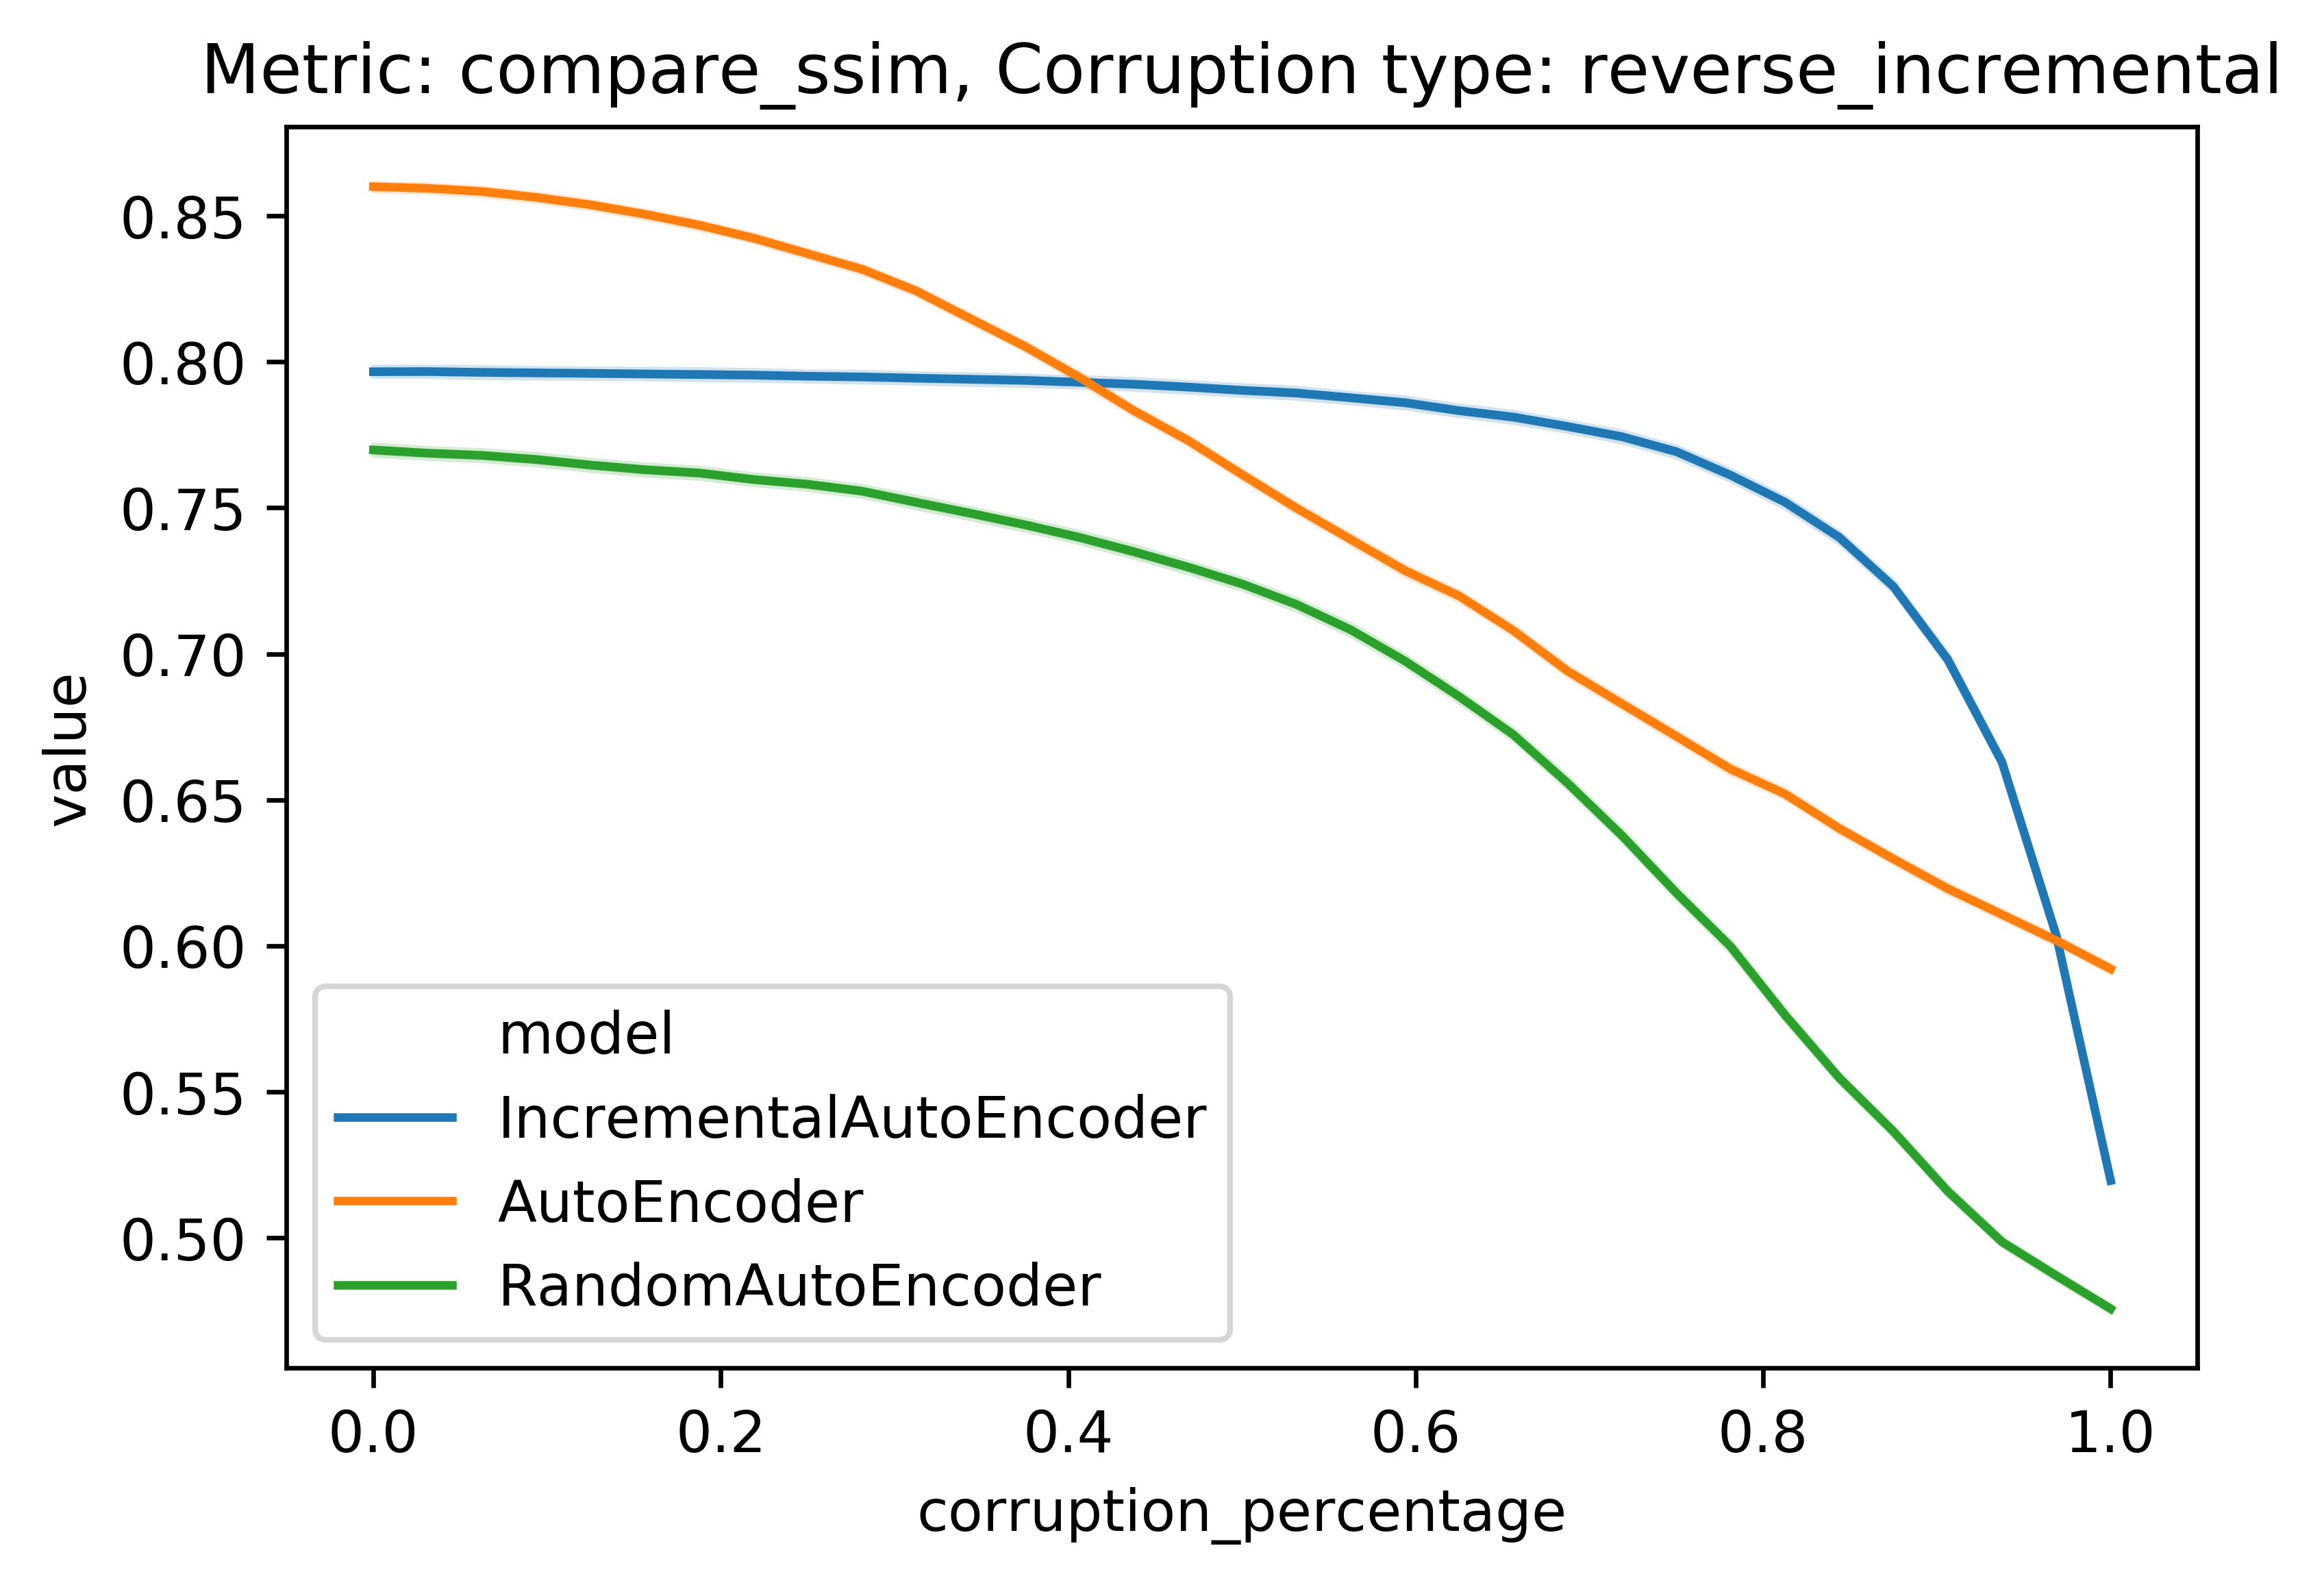

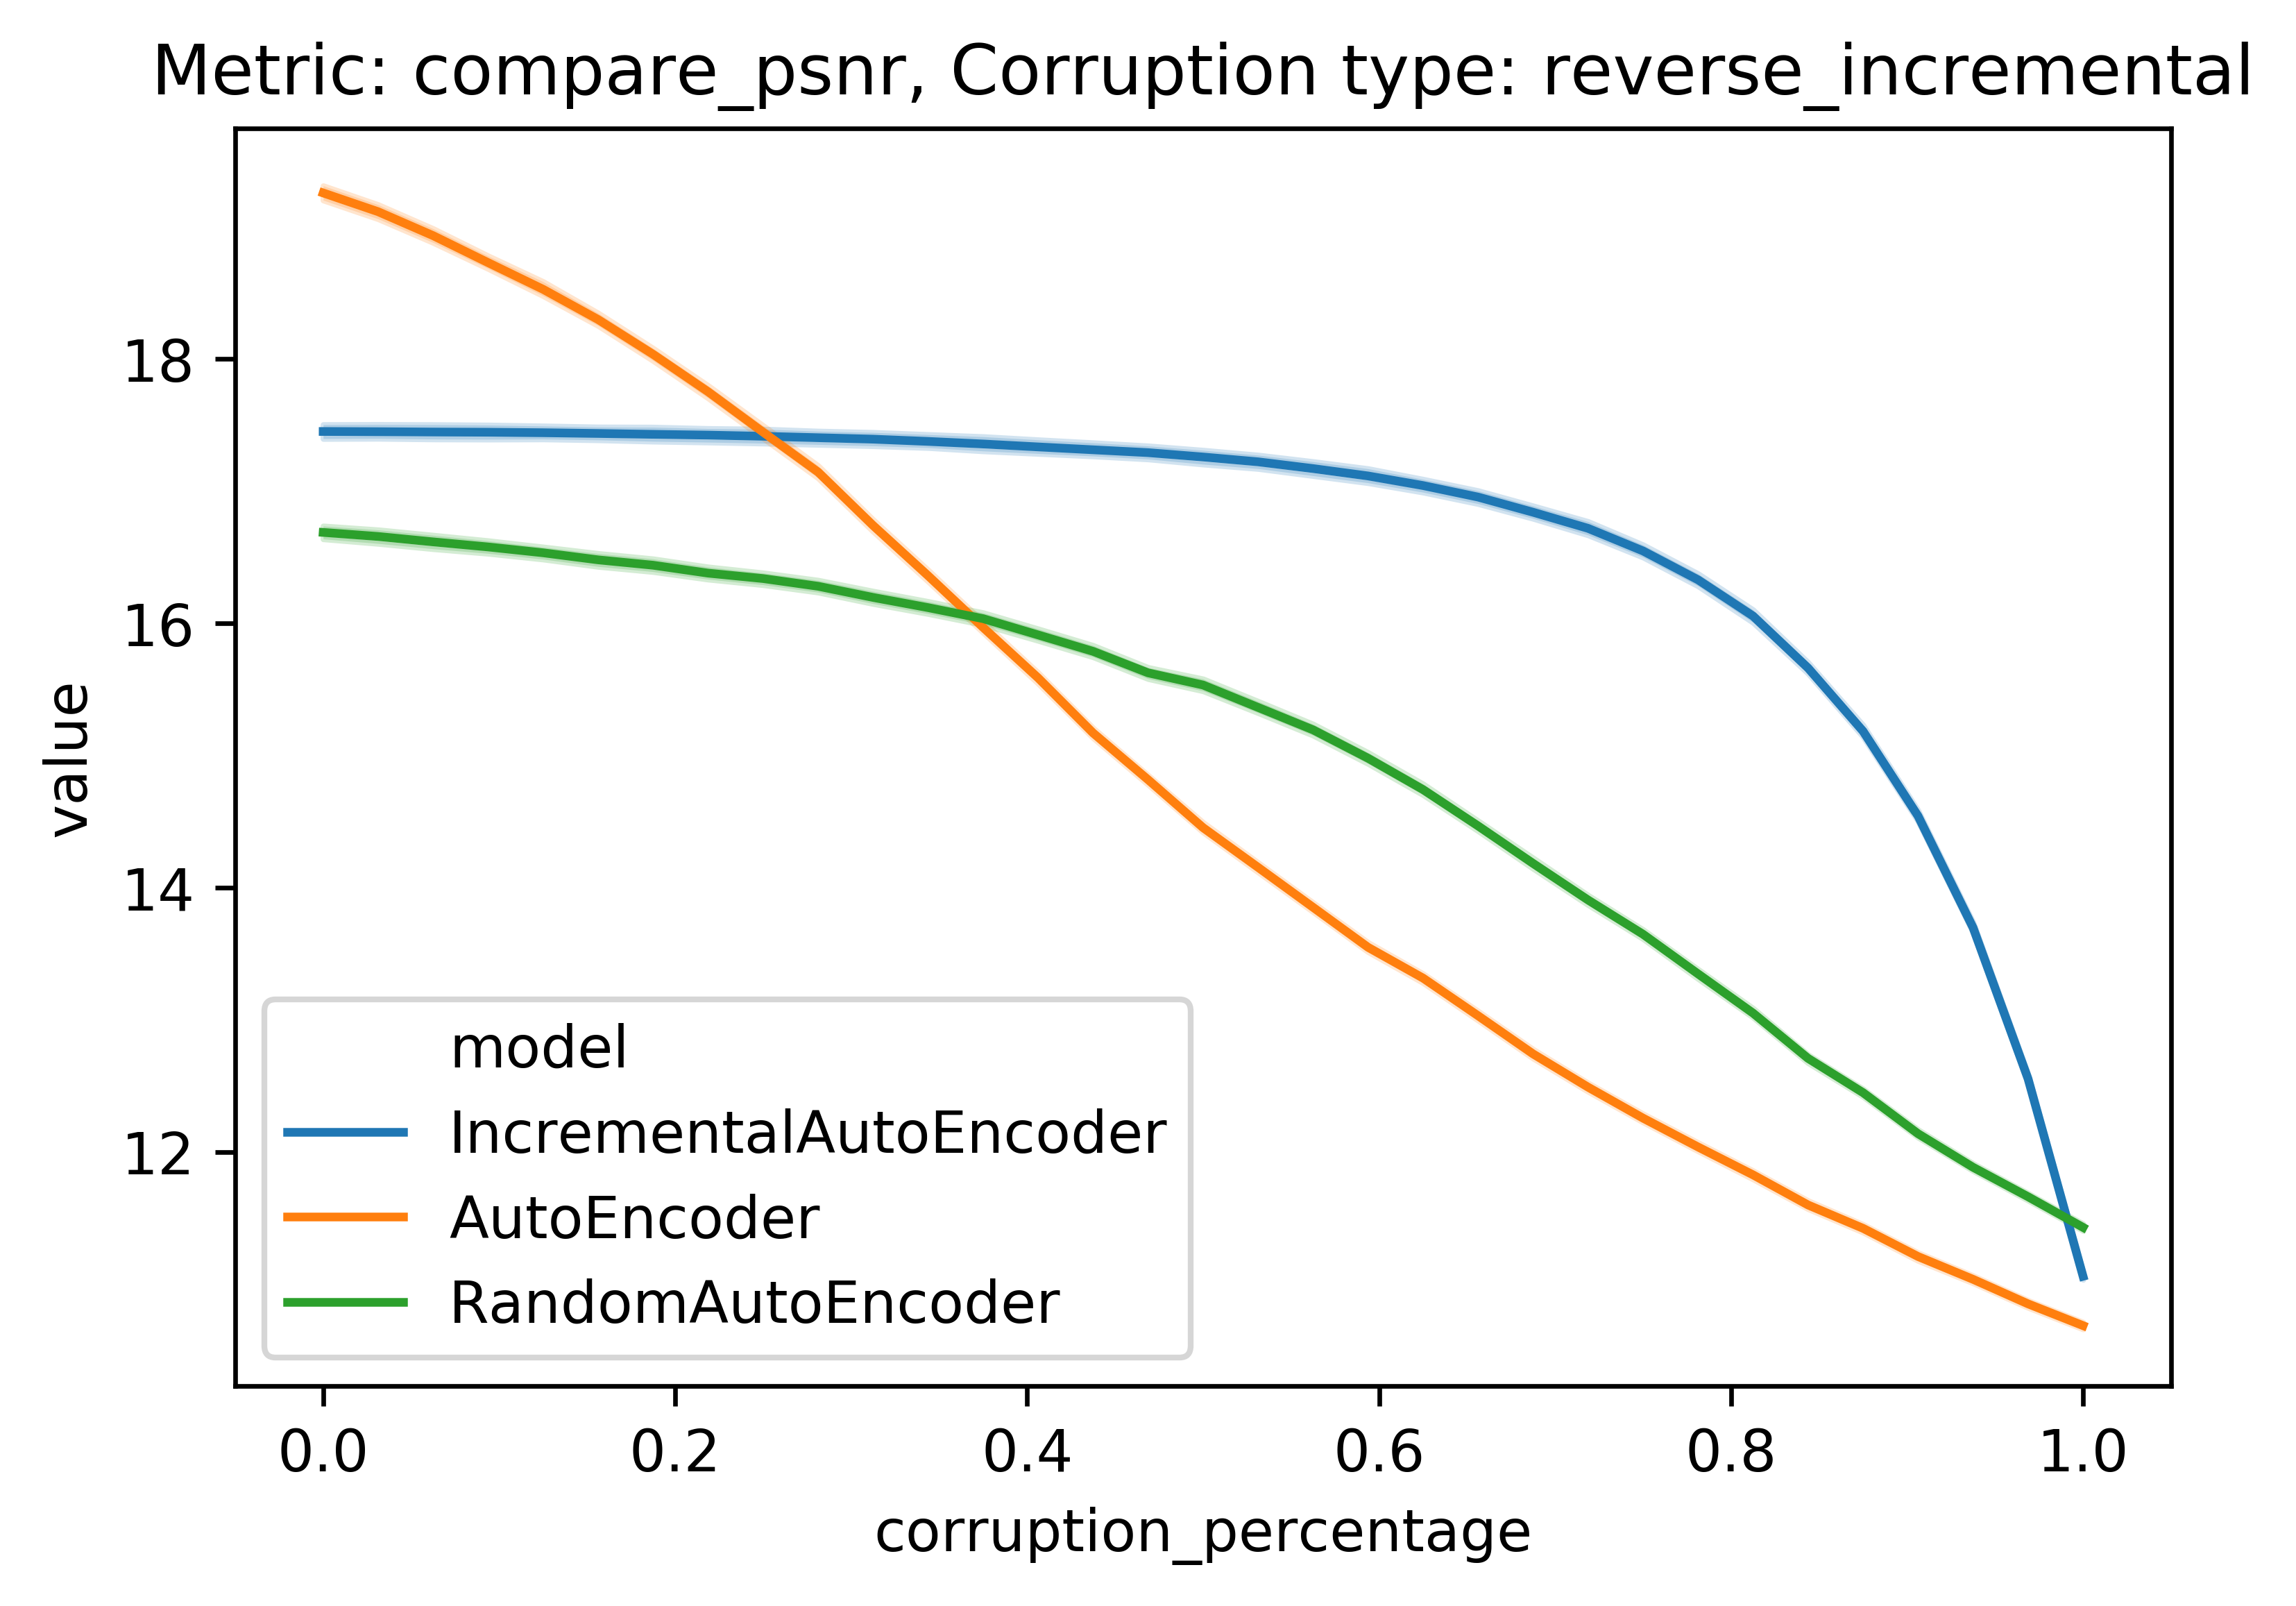

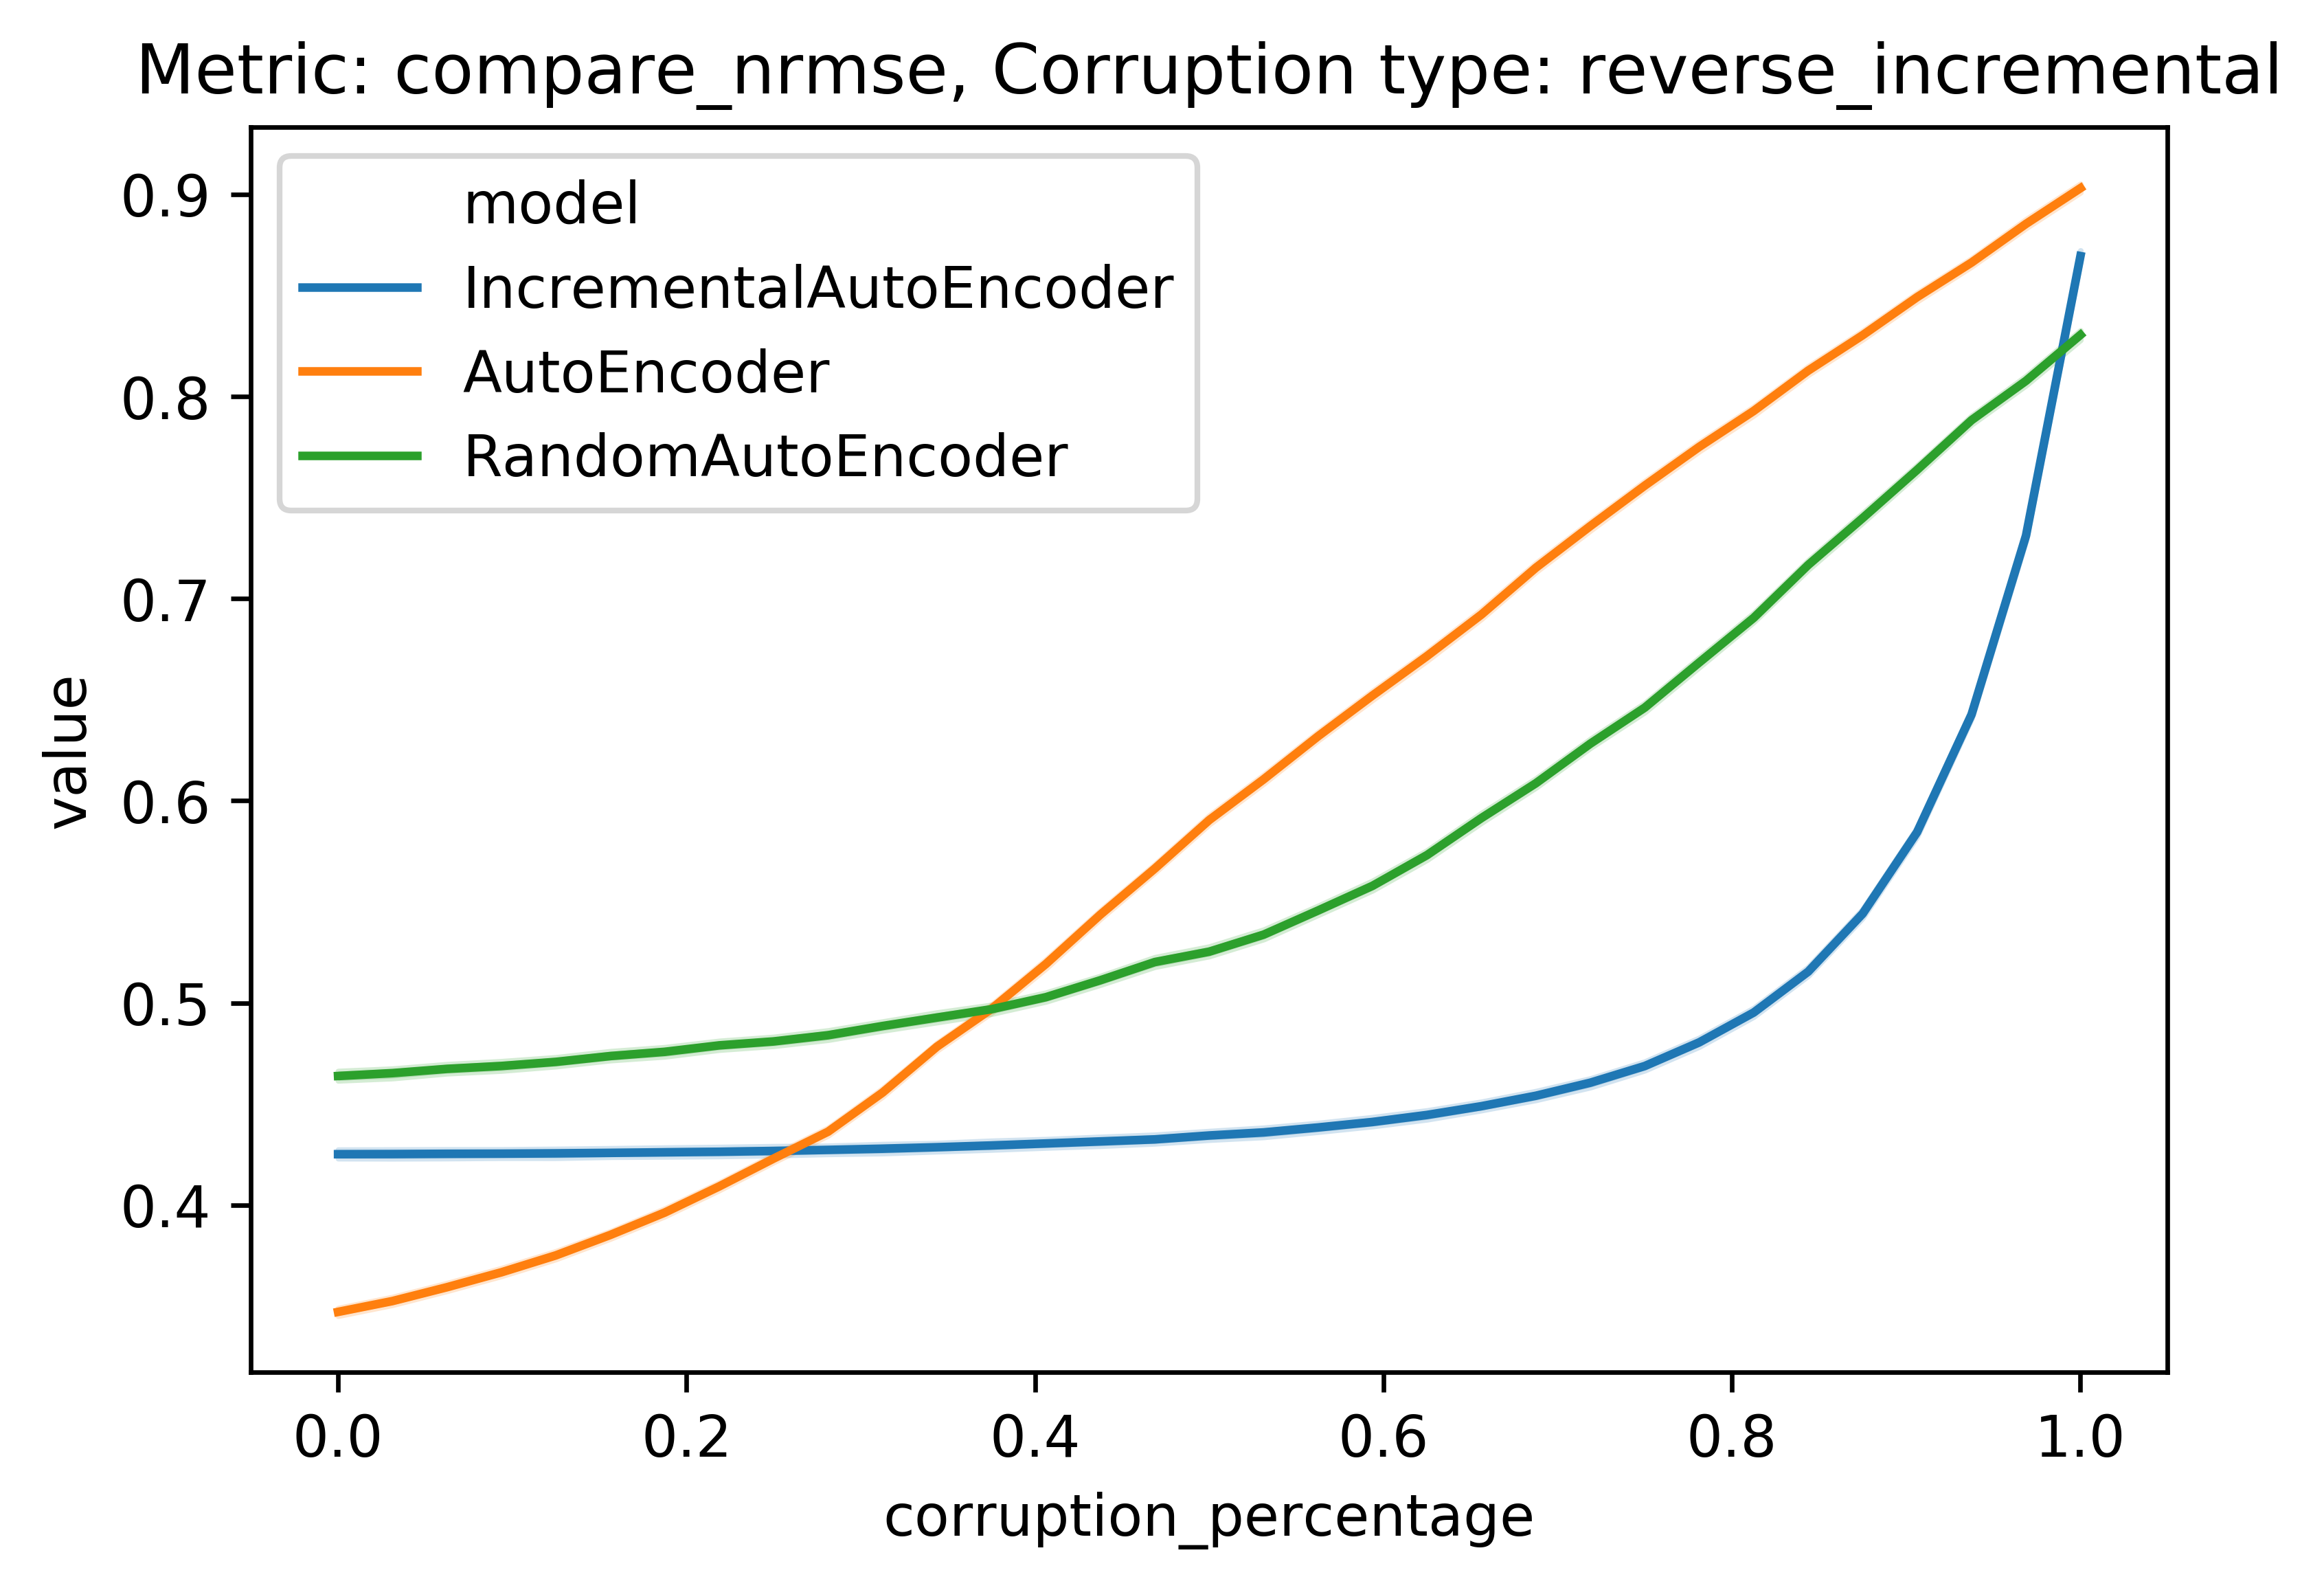

In [3]:
# Plot the graphs for all combinations of similarity measures and corruption types
for corruption_type in ["random", "incremental", "reverse_incremental"]:
    for metric in ["compare_mse", "compare_ssim", "compare_psnr", "compare_nrmse"]:
        plt.figure(dpi=600)
        title_string = "Metric: " + metric + ", Corruption type: " + corruption_type
        sns.lineplot(data=df[(df.metric == metric) & (df.corruption_type == corruption_type)], 
                     x="corruption_percentage", y="value", hue="model").set_title(title_string)
        plt.show()

In [3]:
# Set seed for reproduciblity
torch.manual_seed(7212)
np.random.seed(2980)

In [4]:
# Select which dataset to use
dataset_name = "omniglot"

if dataset_name == "mnist":
    # Mnist digits dataset (download if necessary)
    test_data = torchvision.datasets.MNIST(
        root='./Datasets/mnist/',
        train=False,
        transform=torchvision.transforms.ToTensor(),                        
        download=False,
    )
    img_size = 28
elif dataset_name == "fashion-mnist":
    # Fashion Mnist clothing dataset (download if necessary)
    test_data = torchvision.datasets.FashionMNIST(
        root='./Datasets/fashion-mnist/',
        train=False,
        transform=torchvision.transforms.ToTensor(),                        
        download=False,
    )
    img_size = 28
elif dataset_name == "omniglot":
    # Omniglot alphabets dataset (download if necessary)
    test_data = torchvision.datasets.Omniglot(
        root='./Datasets/omniglot/',
        background=False,
        transform=torchvision.transforms.ToTensor(),                        
        download=False,
    )
    img_size = 105
    
    test_data.data = torch.cat([test_data[i][0]*255 for i in range(len(test_data))])
else:
    print("Could not find dataset")

save_extention = test_data.__class__.__name__

In [5]:
# Select which device to use, use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently running on:", device)

Currently running on: cuda


In [6]:
def load_autoencoder(model_name, saved_as=None, run_on="cpu"):
    
    # Set the save name to the model name if no name was specified
    if not saved_as:
        saved_as = model_name + save_extention
    
    # Select what type of autoencoder to load
    used_autoencoder = getattr(autoencoders, model_name)
    autoencoder = used_autoencoder().to(run_on)

    # Load the weights from the saved file
    autoencoder.load_state_dict(torch.load("./Trained Models/" + saved_as + ".pt", ))
    
    # Set the training flag to False
    autoencoder.eval()
    
    print("Loaded:", model_name, "| In Cuda:", next(autoencoder.parameters()).is_cuda)
    return autoencoder

In [7]:
# Load the saved weights to the autoencoders
# incremental_autoencoder = load_autoencoder("IncrementalAutoEncoder", run_on=device)
# random_autoencoder = load_autoencoder("RandomAutoEncoder", run_on=device)
autoencoder = load_autoencoder("LargeAutoEncoder", run_on=device)

Loaded: LargeAutoEncoder | In Cuda: True


In [8]:
def show_test_images(autoencoder, test_data, n_test_img=5, corruption_type=None, k=0):
    view_data = test_data.data[:n_test_img].view(-1, img_size*img_size).type(torch.FloatTensor).to(device)/255
    
    encoded_images = autoencoder.encoder(view_data)
    binary_encoded = RelaxedBernoulliStraightThrough(1, logits=encoded_images).rsample()
    
    x,y = binary_encoded.shape

    if corruption_type == "random" or corruption_type == "incremental":
        bit_map = np.concatenate((np.zeros((x,y-k)), np.ones((x, k))), axis=1)
        if corruption_type == "random":
            for row in bit_map: np.random.shuffle(row)
        mask = np.where(bit_map)
    elif k==0:
        mask = []
    else:
        print("Failed to recognize the corruption type. Should be either incremental or random")
        return None
    
    binary_encoded[mask] = torch.distributions.Bernoulli(probs=(torch.ones(x,y)/2)).sample().to(device)[mask]

    decoded_images = autoencoder.decoder(binary_encoded)

    # initialize figure
    f, a = plt.subplots(2, n_test_img, figsize=(n_test_img, 2))

    for i in range(n_test_img):
        a[0][i].imshow(np.reshape(view_data.data.cpu().numpy()[i], (img_size, img_size)), cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(n_test_img):
        a[1][i].clear()
        a[1][i].imshow(np.reshape(decoded_images.data.cpu().numpy()[i], (img_size, img_size)), cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show(); plt.pause(0.05)

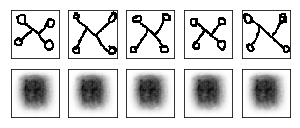

In [9]:
show_test_images(autoencoder, test_data, corruption_type="incremental")
# show_test_images(incremental_autoencoder, test_data, corruption_type="incremental", k=192)
# show_test_images(random_autoencoder, test_data, corruption_type="incremental", k=192)